# Human Action Recognition using Deep Learning

## Import libs

In [1]:
import os
import math
import numpy as np
from numpy import array

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

np.random.seed(777)
tf.random.set_seed(777)
myPath = './'
nHSK = 18 # openPose # mediaPipe 
nBHSK = 14 # eye delete

## gDrive mount

In [2]:
print(tf.__version__)
tf.test.gpu_device_name()
from google.colab import drive
drive.mount('/content/drive')
myPath = '/content/drive/MyDrive/Proposal/SIIF2021/DeepLearning/'

2.9.2
Mounted at /content/drive


## Load data

#### (스쿼트)운동(exercise) 10렙(repetition) 1세트(set) 운동 하나의 동영상파일로 저장. realsensor depth camera d415, d455로 640x480 1초에 30frame으로 bag file format으로 저장. 이를 1초에 10frame 정도 샘플링하여 mediapipe pose를 실행하여 3d 관절 좌표 획득. 다음 csv 파일로 저장한다.
#### 0 total frame index 전체 프레임 인덱스
#### 1 set frame index 세트 운동에서 프레임 인덱스 
#### 2 repetition index 세트 운동에서 렙 인덱스(0~9)
#### 3 repetition frame index 렙에서 프레임 인덱스 
#### 4 exercise type - bentch press, shoulder press, deadlift, squat 
#### 5 exercise status - normal, left, right, drop, ...

In [3]:
filename = 'M221111_1629' #M221111_1409 M221022_2032 M221008_1212
data = pd.read_csv(myPath+'data/'+filename+'.csv') 
data.shape == data.dropna().shape # True: NaN data is not exist

True

In [4]:
n, w = 5, 100
pd.set_option('display.max_columns', w)
pd.set_option('display.width', w)
data.iloc[:,6:42] = data.iloc[:,6:42].astype('float64')

In [5]:
data.head(n)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0,0,0,0,0,2,0.503770,0.196702,0.508198,0.306828,0.445746,0.309096,0.387366,0.254015,0.367256,0.116655,0.570649,0.304559,0.634689,0.239598,0.663421,0.118090,0.465858,0.551936,0.378920,0.715605,0.424702,0.793459,0.559573,0.553203,0.646947,0.725772,0.600030,0.785166,0.492233,0.199750,0.516928,0.197523,0.477648,0.222529,0.532247,0.216406
1,1,1,0,1,0,2,0.503378,0.200097,0.508163,0.308669,0.445949,0.310771,0.387004,0.254169,0.366822,0.118374,0.570377,0.306568,0.634379,0.242308,0.665018,0.120198,0.464833,0.552162,0.378324,0.712249,0.422147,0.794234,0.558364,0.555335,0.647614,0.726969,0.600040,0.785334,0.492041,0.202476,0.516641,0.199994,0.477889,0.223950,0.531896,0.218473
2,2,2,0,2,0,2,0.504700,0.196912,0.508686,0.308069,0.446236,0.309779,0.386745,0.256427,0.366960,0.118966,0.571135,0.306358,0.635501,0.241624,0.668932,0.115796,0.464655,0.551756,0.378063,0.710533,0.422388,0.794027,0.558482,0.555563,0.647849,0.730995,0.602290,0.789605,0.493043,0.200658,0.517269,0.198093,0.478472,0.222814,0.531963,0.217986
3,3,3,0,3,0,2,0.502907,0.197342,0.508078,0.308418,0.445513,0.310737,0.385553,0.254462,0.368177,0.118493,0.570644,0.306100,0.635635,0.245116,0.668805,0.120057,0.465534,0.552126,0.378231,0.710696,0.421713,0.794854,0.559224,0.555173,0.648691,0.732967,0.603836,0.789316,0.491641,0.200739,0.515712,0.198515,0.477478,0.223565,0.530991,0.218617
4,4,4,0,4,0,2,0.504363,0.197685,0.508716,0.308278,0.446637,0.310255,0.385353,0.258194,0.365407,0.119419,0.570796,0.306302,0.635405,0.245334,0.668440,0.116943,0.466194,0.551995,0.378935,0.709672,0.420318,0.795596,0.559381,0.554526,0.648484,0.732117,0.603368,0.788667,0.492941,0.200741,0.517050,0.198209,0.478420,0.222943,0.531422,0.218004


In [6]:
data.tail(n)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
144970,144970,342,10,25,3,0,0.497263,0.293003,0.500235,0.370680,0.448102,0.371030,0.404023,0.458022,0.387657,0.370765,0.552369,0.370329,0.591073,0.453513,0.605448,0.359578,0.473942,0.592104,0.454761,0.738817,0.445458,0.875746,0.534488,0.589895,0.547773,0.739412,0.550631,0.876535,0.486957,0.277048,0.508740,0.277136,0.479577,0.283545,0.519166,0.283736
144971,144971,343,10,26,3,0,0.497936,0.293423,0.500616,0.371750,0.448215,0.372067,0.403977,0.458931,0.387035,0.370359,0.553017,0.371432,0.591259,0.454297,0.606724,0.360697,0.473902,0.591521,0.454228,0.738583,0.445677,0.876135,0.534906,0.589549,0.548130,0.737918,0.550608,0.877246,0.487672,0.277462,0.509595,0.277692,0.480277,0.284110,0.520013,0.284646
144972,144972,344,10,27,3,0,0.498932,0.295496,0.500155,0.372638,0.447691,0.372982,0.403430,0.459457,0.385586,0.369271,0.552618,0.372295,0.591758,0.454481,0.606545,0.362487,0.473792,0.593776,0.453376,0.740737,0.445429,0.877034,0.534754,0.591953,0.548491,0.738596,0.550399,0.876981,0.488352,0.278959,0.510117,0.279531,0.480511,0.285075,0.520234,0.286258
144973,144973,345,10,28,3,0,0.499495,0.296478,0.500323,0.373091,0.447804,0.373358,0.404117,0.459784,0.384698,0.370486,0.552842,0.372824,0.592512,0.456261,0.606719,0.365827,0.473572,0.594450,0.453351,0.740298,0.445862,0.877240,0.534491,0.592820,0.549232,0.741830,0.549668,0.877479,0.488817,0.279625,0.511013,0.280268,0.480849,0.285473,0.520843,0.287022
144974,144974,346,10,29,3,0,0.500019,0.297200,0.500814,0.373232,0.448539,0.373193,0.404546,0.460598,0.384960,0.372741,0.553089,0.373271,0.592255,0.457403,0.607819,0.367353,0.473834,0.595418,0.453170,0.740823,0.445967,0.876987,0.534340,0.593695,0.548903,0.742906,0.550020,0.877402,0.489058,0.280042,0.511948,0.280725,0.481218,0.285808,0.521623,0.287521


In [7]:
data = data.sort_values(['4', '5', '0'])

In [8]:
data.head(n)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
3188,3188,0,0,0,0,0,0.499608,0.194749,0.502411,0.311852,0.438370,0.315280,0.371690,0.267655,0.365272,0.129593,0.566453,0.308425,0.643461,0.251285,0.678149,0.120000,0.465528,0.557754,0.374243,0.715248,0.415919,0.793255,0.560437,0.556006,0.657150,0.720429,0.608417,0.791140,0.486904,0.196360,0.512901,0.195353,0.471350,0.218275,0.526890,0.214617
3189,3189,1,0,1,0,0,0.499166,0.194622,0.502862,0.312471,0.438775,0.315769,0.371163,0.266813,0.367635,0.126572,0.566949,0.309174,0.643568,0.251620,0.677111,0.117891,0.466106,0.556981,0.374274,0.712596,0.413743,0.792577,0.561147,0.554856,0.657503,0.720101,0.608519,0.790808,0.486852,0.196804,0.512440,0.195705,0.471971,0.218642,0.526998,0.215435
3190,3190,2,0,2,0,0,0.498267,0.193123,0.503353,0.313394,0.439568,0.316857,0.374136,0.266334,0.367729,0.125109,0.567138,0.309931,0.644002,0.250841,0.678326,0.119097,0.466587,0.557024,0.374515,0.713046,0.413299,0.792211,0.561697,0.556046,0.659040,0.721427,0.607940,0.788345,0.486436,0.196328,0.511532,0.194569,0.472338,0.219164,0.527205,0.216234
3191,3191,3,0,3,0,0,0.498433,0.191813,0.503920,0.312557,0.440263,0.315961,0.375067,0.265360,0.367898,0.123764,0.567577,0.309153,0.643412,0.251193,0.678543,0.121077,0.466573,0.557014,0.374765,0.712630,0.412886,0.792801,0.561831,0.555870,0.658696,0.720309,0.608498,0.788170,0.486688,0.195486,0.511509,0.193438,0.472869,0.218323,0.527425,0.214609
3192,3192,4,0,4,0,0,0.498271,0.194894,0.503682,0.312306,0.440085,0.316024,0.375203,0.264890,0.367487,0.124397,0.567279,0.308587,0.642948,0.251647,0.678921,0.120131,0.466571,0.557316,0.374784,0.713116,0.412846,0.792096,0.561207,0.555793,0.659019,0.720568,0.607977,0.788724,0.486261,0.197610,0.511559,0.195652,0.472237,0.219397,0.526984,0.215564


In [9]:
data.tail(n)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
144659,144659,31,0,31,4,4,0.498090,0.295490,0.500554,0.371094,0.448569,0.371782,0.406291,0.461517,0.385175,0.374917,0.552538,0.370405,0.590165,0.454103,0.606386,0.360314,0.470335,0.594945,0.449344,0.745294,0.444855,0.880225,0.531670,0.593955,0.547500,0.745577,0.552765,0.878280,0.487765,0.278688,0.509922,0.279808,0.479996,0.285132,0.521462,0.287116
144660,144660,32,0,32,4,4,0.497422,0.295062,0.500729,0.371840,0.448800,0.372606,0.407730,0.462529,0.387163,0.377070,0.552659,0.371075,0.590321,0.456050,0.607101,0.363762,0.470189,0.594122,0.450268,0.743652,0.445015,0.879991,0.531440,0.593864,0.546825,0.745223,0.551723,0.878253,0.487274,0.278033,0.509370,0.279389,0.479572,0.284450,0.521177,0.287003
144661,144661,33,0,33,4,4,0.496488,0.294376,0.500787,0.372191,0.448638,0.372917,0.407012,0.463056,0.386850,0.377718,0.552936,0.371465,0.592880,0.456619,0.606789,0.364050,0.470097,0.594158,0.450607,0.743430,0.444723,0.880094,0.531613,0.593959,0.547293,0.744701,0.552077,0.876597,0.486719,0.277886,0.508498,0.279095,0.479350,0.284186,0.521055,0.286933
144662,144662,34,0,34,4,4,0.496366,0.292176,0.501459,0.372649,0.449558,0.372859,0.407736,0.463205,0.388673,0.378476,0.553361,0.372439,0.592270,0.457854,0.606439,0.367243,0.470282,0.594116,0.450543,0.743311,0.444788,0.879622,0.531595,0.594137,0.548120,0.744850,0.552316,0.877356,0.486838,0.276705,0.508467,0.277722,0.479823,0.283448,0.521111,0.285889
144663,144663,35,0,35,4,4,0.497153,0.292830,0.501518,0.373054,0.449872,0.372895,0.408168,0.463435,0.390136,0.377696,0.553165,0.373213,0.592568,0.458440,0.607488,0.367855,0.470262,0.594736,0.450007,0.743192,0.444706,0.879278,0.531745,0.594426,0.548338,0.745103,0.552080,0.877281,0.487319,0.276911,0.509525,0.277970,0.480081,0.283398,0.521986,0.285865


In [10]:
#data.to_csv(myPath+'data/'+filename+'s.csv')

In [11]:
X = data.iloc[:, 6:6+2*nHSK] 
Y = data.iloc[:, 4] #4 운동종류 4가지 #5 운동상태  
print(X.shape)
print(Y.shape)

(144975, 36)
(144975,)


In [12]:
eUnique, eCounts = np.unique(Y[:].to_numpy(), return_counts=True)
print(eCounts, sum(eCounts))

[59638 25343 28369 23006  8619] 144975


## Utility & Functions

In [13]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

def axisLine(x0, x1, y0, y1):
  xc = (x0+x1)/2
  yc = (y0+y1)/2
  x = np.array([x0,x1])
  y = np.array([yc,yc])
  plt.plot(x, y, '#888888')
  x = np.array([xc,xc])
  y = np.array([y0,y1])
  plt.plot(x, y, '#888888')

def seqLine(X, i, n, k, l):
  x = np.array([X.iloc[i,2*n*k+2*j] for j in l])
  y = 1-np.array([X.iloc[i,2*n*k+2*j+1] for j in l]) # reverse y-axis 
  plt.plot(x, y, color=colors[k%10])

def hskPlot(X, Y, pY, n, c, m, i, l):
  margin = 0.05
  plt.rcParams['figure.figsize'] = [4*l, 3]
  for j in range(l):
    plt.subplot(1, l, j+1) 
    x = X.iloc[i+j,0:n*c*2:2].to_numpy()
    y = 1-X.iloc[i+j,1:n*c*2:2].to_numpy() # reverse y-axis 
    plt.plot(x, y, color='red', marker='*', linestyle='none', markersize=3)
    if len(Y)>0:
      msg = np.array_str(Y[i+j,:], precision=2, suppress_small=True)
      plt.text(-margin, -3.5*margin, msg, fontsize=12)
      if len(pY)>0:
        msg = np.array_str(pY[i+j,:], precision=2, suppress_small=True)
        diff = abs(Y[i+j,:] - pY[i+j,:])
        if np.linalg.norm(diff) > 0.5:
          plt.text(1-margin, -4*margin, '*', fontdict={'color': 'red', 'size': 20})
          plt.text(-margin, -6.5*margin, msg, fontdict={'color': 'red', 'size': 12})
        else:
          plt.text(-margin, -6.5*margin, msg, fontsize=12)
      plt.ylim([-0.3-m, 1+m])
    else:
      plt.ylim([-m, 1+m])

    for k in range(c):
      seqLine(X, i+j, n, k, [0, 1, 2, 3, 4])
      seqLine(X, i+j, n, k, [1, 5, 6, 7])
      seqLine(X, i+j, n, k, [1, 8, 9, 10])
      seqLine(X, i+j, n, k, [1, 11, 12, 13])
    axisLine(0,1,0,1)
    plt.title("hsk-"+str(i+j)); 
    plt.xlim([-m, 1+m])
    plt.grid(True); 
  plt.show()   

In [14]:
# encoder_Y = [0]*744 + [1]*722 + [2]*815 + [3]*1008
# Encoder the class label to number
# Converts a class vector (integers) to binary class matrix
def catgr(counts):
  transY = []
  for i in range(len(counts)):
    for j in range(counts[i]):
      transY.append(i)  
  catgrY = tf.keras.utils.to_categorical(transY)
  return  catgrY 

In [15]:
def head_reference(X, n):
  Xh = X[:,0:2*n].copy()
  for i in range(len(X)):
    cx = X[i, 2] - 0.5 #neck_x
    cy = X[i, 3] - 0.5 #neck_y
    for j in range(0, n):
      Xh[i, j*2] = X[i, j*2] - cx
      Xh[i, j*2+1] = X[i, j*2+1] - cy
  return Xh

In [16]:
def pose_normalization(x, n):
  def retrain_only_body_joints(x_input, n):
    x0 = x_input.copy()
    x0 = x0[0:n*2]
    return x0

  def normalize(x_input):
    # Separate original data into x_list and y_list
    lx = []
    ly = []
    N = len(x_input)
    i = 0
    while i<N:
      lx.append(x_input[i])
      ly.append(x_input[i+1])
      i+=2
    lx = np.array(lx)
    ly = np.array(ly)

    # Get rid of undetected data (=0)
    non_zero_x = []
    non_zero_y = []
    for i in range(int(N/2)):
      if lx[i] != 0:
        non_zero_x.append(lx[i])
      if ly[i] != 0:
        non_zero_y.append(ly[i])
    if len(non_zero_x) == 0 or len(non_zero_y) == 0:
      return np.array([0] * N)

    # Normalization x/y data according to the bounding box
    origin_x = np.min(non_zero_x)
    origin_y = np.min(non_zero_y)
    len_x = np.max(non_zero_x) - np.min(non_zero_x)
    len_y = np.max(non_zero_y) - np.min(non_zero_y)
    eps = 0.0001
    if len_x < eps:
      len_x = 1
    if len_y < eps:
      len_y = 1
    x_new = []
    for i in range(int(N/2)):
      if (lx[i] + ly[i]) == 0:
        x_new.append(-1)
        x_new.append(-1)
      else:
        x_new.append((lx[i] - origin_x) / len_x)
        x_new.append((ly[i] - origin_y) / len_y)
    return x_new

  x_body_joints_xy = retrain_only_body_joints(x, n)
  x_body_joints_xy = normalize(x_body_joints_xy)
  return x_body_joints_xy

In [17]:
def pos2angles(sk):
  def get(i):
    return sk[i*2:i*2+2]

  # Calculate the joint angles for elbow, hip and knee
  def calc_angle(p1,p2,p3):
    dp1 = p1-p2
    dp2 = p3-p2
    if np.linalg.norm(dp1)*np.linalg.norm(dp2) == 0:
      return -1
    else:
      res = dp1.dot(dp2)/(np.linalg.norm(dp1)*np.linalg.norm(dp2))
      return res

  # Claculate angles for shouder
  def calc_angle_shoulder(p1,p2,p3):
    dp1 = p1-p2
    dp2 = p3-p2
    if np.linalg.norm(dp1)*np.linalg.norm(dp2) == 0:
      return 0
    else:
      res = dp1.dot(dp2)/(np.linalg.norm(dp1)*np.linalg.norm(dp2))
      return res

  p_neck = get(1)
  p_r_shoulder =  get(2)
  p_r_elbow =  get(3)
  p_r_wrist =  get(4)
  a_r_shoulder = calc_angle_shoulder(p_neck, p_r_shoulder, p_r_elbow)
  a_r_elbow = calc_angle(p_r_shoulder, p_r_elbow, p_r_wrist)

  p_l_shoulder =  get(5)
  p_l_elbow =  get(6)
  p_l_wrist =  get(7)
  a_l_shoulder = calc_angle_shoulder(p_neck, p_l_shoulder, p_l_elbow)
  a_l_elbow = calc_angle(p_l_shoulder, p_l_elbow, p_l_wrist)

  p_r_hip = get(8)
  p_r_knee = get(9)
  p_r_ankle = get(10)
  a_r_hip = calc_angle(p_neck, p_r_hip, p_r_knee)
  a_r_knee = calc_angle(p_r_hip, p_r_knee, p_r_ankle)

  p_l_hip = get(11)
  p_l_knee = get(12)
  p_l_ankle = get(13)
  a_l_hip = calc_angle(p_neck, p_l_hip, p_l_knee)
  a_l_knee = calc_angle(p_l_hip, p_l_knee, p_l_ankle)

  angles = [a_r_shoulder, a_r_elbow, a_l_shoulder, a_l_elbow, a_r_hip, a_r_knee, a_l_hip, a_l_knee]
  return np.array(angles)

In [18]:
def hskAngPlot(X, Y, pY, m, i, l):
  margin = 0.05
  plt.rcParams['figure.figsize'] = [4*l, 3]
  for j in range(l):
    plt.subplot(1, l, j+1) 
    plt.plot(X.iloc[i+j,:].to_numpy(), 'r*', markersize=3)
    if len(Y)>0:
      msg = np.array_str(Y[i+j,:], precision=2, suppress_small=True)
      plt.text(0, -1-6*margin, msg, fontsize=16)
      if len(pY)>0:
        msg = np.array_str(pY[i+j,:], precision=2, suppress_small=True)
        plt.text(0, -1-12*margin, msg, fontsize=16)
      plt.ylim([-1.6-m, 1+m])
    else :
      plt.ylim([-1-m, 1+m])

    plt.title("hskAng-"+str(i+j)); 
    plt.grid(True); 
  plt.show()   

In [19]:
def checkNaN(x, n):
  l = []
  for i in range(n):
    if np.isnan(x[i]):
      l.append(i)
  return l

def checkNaNData(X):
  lst = []
  for i in range(len(X)):
    m = checkNaN(X.iloc[i,:].to_numpy(), 6)
    if len(m) > 0 :
      lst.append([i, m])
  lst = np.array(lst)    
  return lst

In [20]:
def multiFrameX(X, counts, frames):
  mX = []
  mC = counts.copy()
  k = 0
  for i in range(len(counts)):
    size = counts[i]-frames+1
    mC[i] = counts[i]-frames+1
    for j in range(size):
      mX.append(X.iloc[k+j:k+j+frames,:].values.reshape(1,-1))
    k += counts[i]  
  mX = np.array(mX).reshape(len(mX),-1)
  mX = pd.DataFrame(mX)
  return mX, mC

In [21]:
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

## Unique & counts - restart here

In [77]:
unique, counts = np.unique(Y[:].to_numpy(), return_counts=True)
print(counts, sum(counts))
dict(zip(unique, counts))
uniqueNum = unique.shape[0]

[25395 17200 17043] 59638


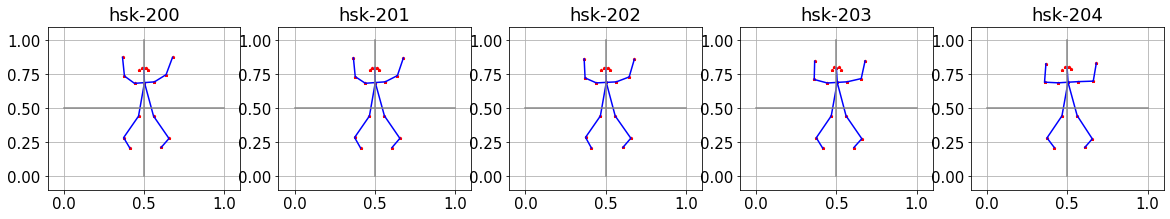

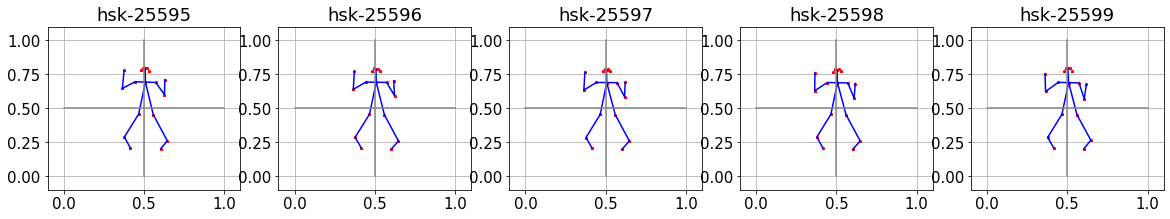

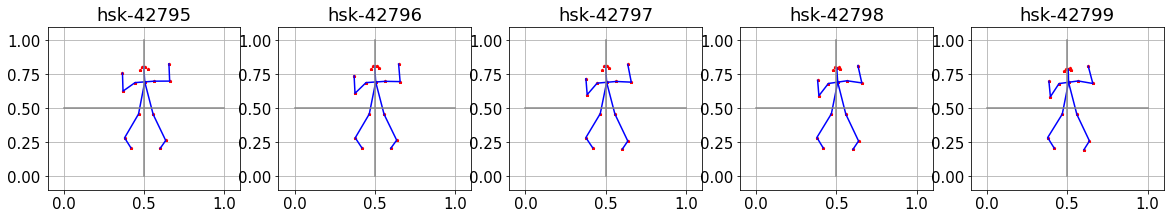

In [79]:
# [939 522 501 427 117]
n0, n1, n2 = 200, 5, uniqueNum
for i in range(n2):
  hskPlot(X, [], [], nHSK, 1, 0.1, sum(counts[0:i])+n0, n1) #[ 744  722  815 1008  811]
fillX = X.copy()

## Missing data -- Skip

In [ ]:
def checkMissingRow(x, n):
  l = []
  for i in range(n):
    if x[2*i] == 0 or x[2*i+1] == 0:
      l.append(i)
  return l
  
def checkMissingData(X):
  mlst = []
  for i in range(len(X)):
    m = checkMissingRow(X.iloc[i,:].to_numpy(), nBHSK)
    l = len(m)
    split = -1
    if l > 0 :
      if m == [4, 7] or m == [10, 13] or m == [4, 13] or m == [7, 10] or m == [4, 6, 7] or m == [10, 12, 13] or m == [7, 9, 10] or \
        m == [4, 5, 6, 7] or m == [10, 11, 12, 13]:
        split = 1
      elif m == [3, 4, 7] or m == [3, 4, 13] or m == [9, 10, 13] or m == [3, 4, 6, 7] or m == [3, 4, 12, 13] or m == [6, 7, 9, 10] or \
        m == [9, 10, 12, 13] or m == [3, 4, 5, 6, 7] or m == [9, 10, 11, 12, 13]:
        split = 2
      elif m == [2, 3, 4, 7] or m == [2, 3, 4, 10] or m == [2, 3, 4, 11] or m == [2, 3, 4, 12] or m == [2, 3, 4, 13] or m == [8, 9, 10, 13] or \
        m == [5, 6, 7, 8] or m == [5, 6, 7, 9] or m == [5, 6, 7, 10] or m == [2, 3, 4, 6, 7] or m == [8, 9, 10, 12, 13] or m == [2, 3, 4, 5, 6, 7]:
        split = 3

      if split != -1:
        p1 = m[0:split]
        mlst.append([i, p1])  
        p2 = m[split:l]
        mlst.append([i, p2]) 
        # print(i, m, '-->', p1, p2)
      else:     
        mlst.append([i, m])
        # print(i, m)

  mlst = np.array(mlst)    
  return mlst

In [ ]:
missingList = checkMissingData(X)
print(len(missingList), X.shape)      
print(missingList)  

0 (59638, 36)
[]


In [ ]:
def fillMissingData(X, mlst):
  for i in range(len(mlst)):
    if mlst[i][1] == [0]:
      j = mlst[i][0]
      for k in mlst[i][1]:
        X.iloc[j,2*k] = X.iloc[j,2*(k+1)]
        X.iloc[j,2*k+1] = X.iloc[j,2*(k+1)+1]
    elif mlst[i][1] == [4] or mlst[i][1] == [7] or mlst[i][1] == [3] or mlst[i][1] == [6] or mlst[i][1] == [10] or mlst[i][1] == [13]:
      j = mlst[i][0]
      for k in mlst[i][1]:
        X.iloc[j,2*k] = X.iloc[j,2*(k-1)]
        X.iloc[j,2*k+1] = X.iloc[j,2*(k-1)+1]
    elif mlst[i][1] == [3, 4] or mlst[i][1] == [6, 7] or mlst[i][1] == [9, 10] or mlst[i][1] == [12, 13]:
      j = mlst[i][0]
      l = mlst[i][1][0]
      for k in mlst[i][1]:
        X.iloc[j,2*k] = X.iloc[j,2*(l-1)]
        X.iloc[j,2*k+1] = X.iloc[j,2*(l-1)+1]
    elif mlst[i][1] == [2, 3, 4] or mlst[i][1] == [5, 6, 7] or mlst[i][1] == [8, 9, 10] or mlst[i][1] == [11, 12, 13]:
      j = mlst[i][0]
      l = 1
      for k in mlst[i][1]:
        X.iloc[j,2*k] = X.iloc[j,2*l]
        X.iloc[j,2*k+1] = X.iloc[j,2*l+1]
  return X      

In [ ]:
fillX = X.copy()
fillX = fillMissingData(fillX, missingList)

In [ ]:
np.set_printoptions(linewidth=np.inf)
if(len(missingList)>n):
  for i in range(n):
    print(missingList[i][0])
    print(X.iloc[missingList[i][0],:].to_numpy())
    print(fillX.iloc[missingList[i][0],:].to_numpy())

In [ ]:
checkMissingList = checkMissingData(fillX)
print(len(checkMissingList), X.shape)      
print(checkMissingList)  

0 (2506, 36)
[]


In [ ]:
def dropMissingData(X, Y, mlst):
  n = len(mlst)-1
  for i in range(n+1):   
    X = X.drop(mlst[n-i][0])
    Y = Y.drop(mlst[n-i][0])
  return X, Y

#dropFillX = fillX.copy()
#dropY = Y.copy()
#dropFillX, dropY = dropMissingData(dropFillX, dropY, checkMissingList)

#dropUnique, dropCounts = np.unique(dropY[:].to_numpy(), return_counts=True)
#print(dropCounts, sum(dropCounts))
#dict(zip(dropUnique, dropCounts))

In [ ]:
def fillMissingRowData(X, mlst):
  for i in range(len(mlst)):
    k = mlst[i][0]
    print(k, mlst[i][1])
    for j in mlst[i][1]:
      X.iloc[k][2*j:2*j+2] = X.iloc[k-1][2*j:2*j+2] 
  return X    

In [ ]:
fillX = fillMissingRowData(fillX, checkMissingList)

In [ ]:
np.set_printoptions(linewidth=np.inf)
if(len(checkMissingList)>n) :
  for i in range(n):
    print(checkMissingList[i][0])
    print(X.iloc[checkMissingList[i][0],:].to_numpy())
    print(fillX.iloc[checkMissingList[i][0],:].to_numpy())

In [ ]:
print(len(checkMissingList), X.shape)

0 (2506, 36)


In [ ]:
n1, n2 = 800, 820
print(Y.iloc[n1:n2].to_frame().T) 
print(fillX.iloc[n1:n2,0:10])

   2367  2368  2369  2370  2371  2372  2373  2374  2375  2376  2377  2378  2379  2380  2381  2382  2383  2384  2385  2386
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
             6         7         8         9        10        11        12        13        14        15
2367  0.501568  0.303656  0.509332  0.377424  0.457873  0.379025  0.416407  0.462826  0.412032  0.372695
2368  0.501497  0.327670  0.509775  0.397544  0.457683  0.399542  0.415948  0.482715  0.409669  0.394226
2369  0.504151  0.350150  0.510112  0.418392  0.457642  0.420121  0.417207  0.504376  0.412887  0.415656
2370  0.505312  0.373785  0.509541  0.438961  0.457352  0.440790  0.414922  0.524169  0.412888  0.437267
2371  0.503359  0.394449  0.510024  0.459073  0.457590  0.460377  0.413722  0.540858  0.406216  0.458616
2372  0.504371  0.417506  0.509586  0.479304  0.458725  0.479485  0.412519  0.556507  0.411192  0.483567
2373  0.503853  0.440

In [ ]:
print(checkMissingData(fillX))  

[]


## Neck center

In [24]:
fillXBody = fillX.iloc[:,0:2*nBHSK]
print(fillX.shape)
print(fillXBody.shape)

(144975, 36)
(144975, 28)


In [25]:
fillXBodyNeck = head_reference(np.array(fillXBody), nBHSK)
fillXBodyNeck = pd.DataFrame(fillXBodyNeck)

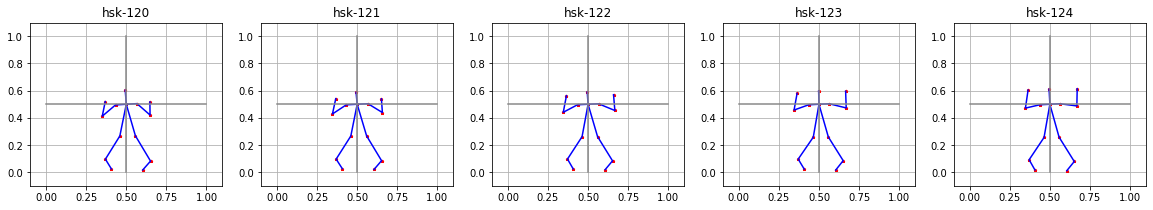

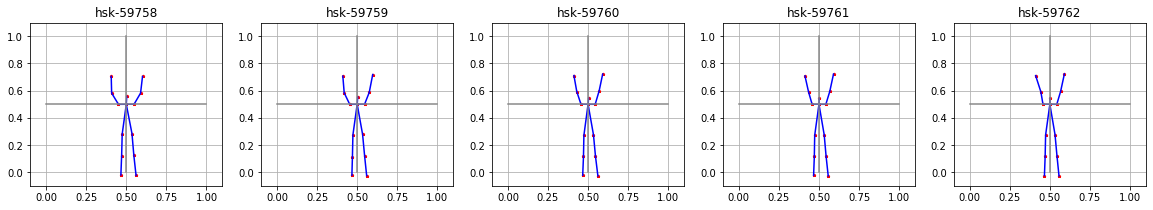

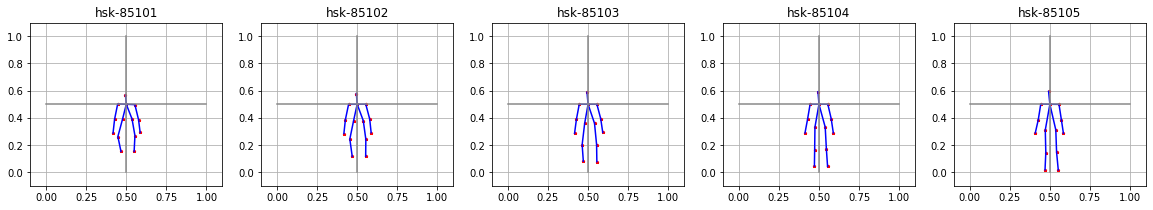

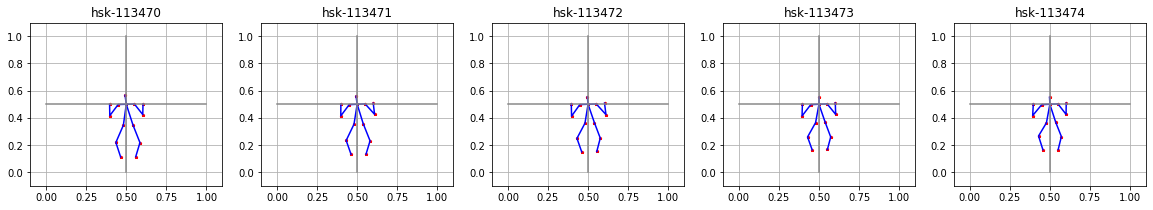

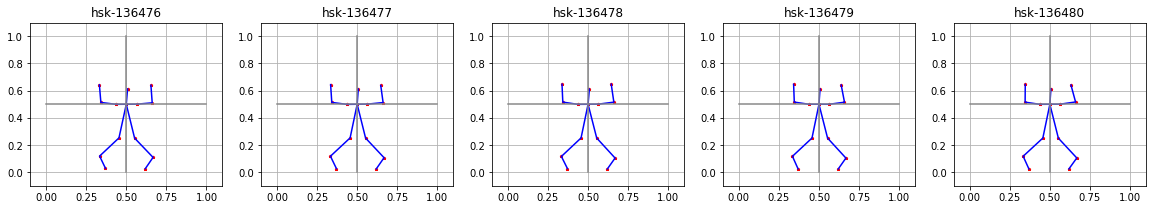

In [26]:
n0, n1, n2 = 120, 5, uniqueNum
for i in range(n2):
  hskPlot(fillXBodyNeck, [], [], nBHSK, 1, 0.1, sum(counts[0:i])+n0, n1) #[ 744  722  815 1008  811]

In [27]:
catgrY = catgr(counts)
#print(type(catgrY))
print(catgrY)
print(len(catgrY))

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
144975


## Data normalization

In [28]:
normalFillXBodyNeck = []
for i in range(len(fillXBodyNeck)):
  normalFillXBodyNeck.append(pose_normalization(fillXBodyNeck.iloc[i,:].to_numpy(), nBHSK))
normalFillXBodyNeck = np.array(normalFillXBodyNeck)
print(normalFillXBodyNeck.shape)
normalFillXBodyNeck = pd.DataFrame(normalFillXBodyNeck)

(144975, 28)


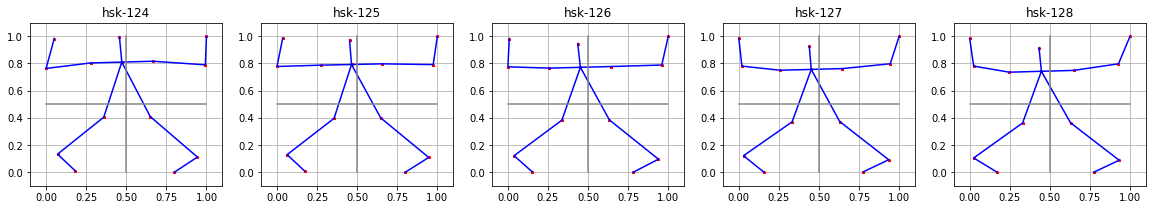

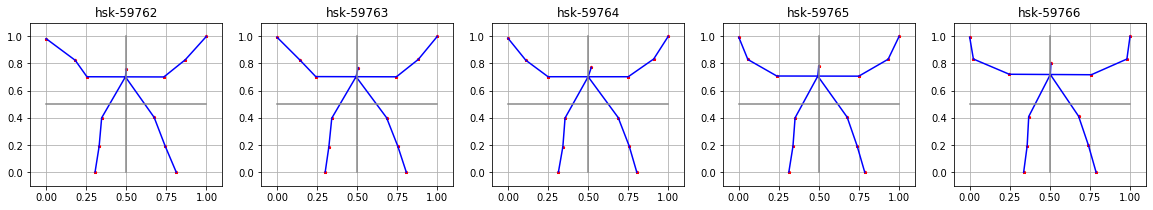

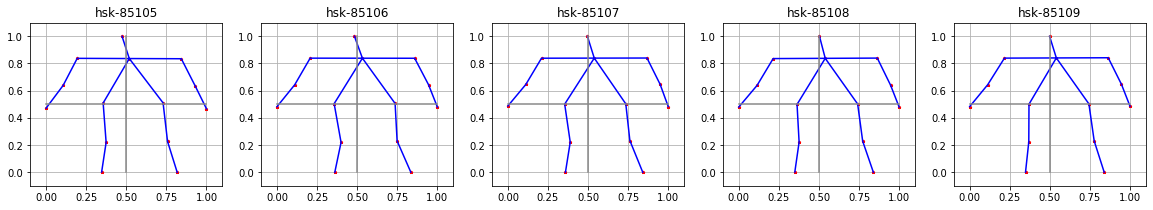

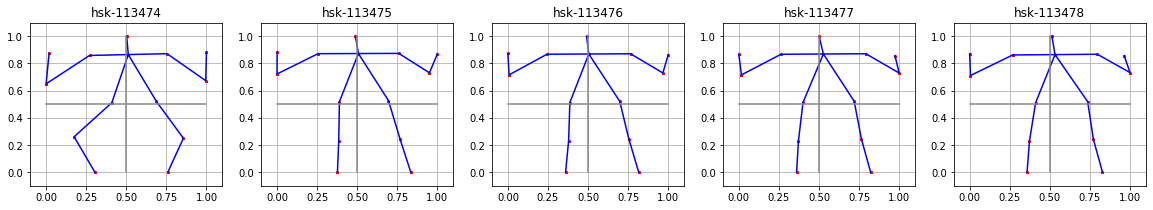

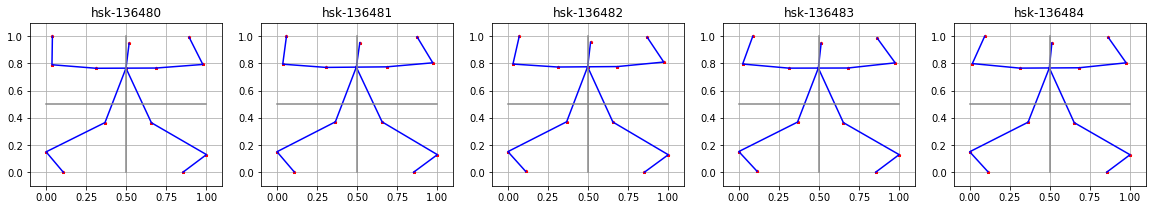

In [29]:
n0, n1, n2 = 124, 5, uniqueNum
for i in range(n2):
  hskPlot(normalFillXBodyNeck, [], [], nBHSK, 1, 0.1, sum(counts[0:i])+n0, n1) #[939 522 501 427 117

In [30]:
print(normalFillXBodyNeck.head(n))
print(normalFillXBodyNeck.tail(n))

         0         1         2         3         4         5         6         7    8         9   \
0  0.429357  0.111027  0.438316  0.284963  0.233631  0.290054  0.020512  0.219316  0.0  0.014249   
1  0.425013  0.113729  0.436955  0.288402  0.229873  0.293290  0.011400  0.220727  0.0  0.012868   
2  0.420281  0.109977  0.436654  0.288654  0.231291  0.293799  0.020626  0.218740  0.0  0.008932   
3  0.420205  0.105305  0.437870  0.285057  0.232950  0.290125  0.023077  0.214796  0.0  0.004001   
4  0.419940  0.111259  0.437316  0.285989  0.233108  0.291523  0.024775  0.215426  0.0  0.006348   

         10        11        12        13   14   15        16        17        18        19  \
0  0.643001  0.279872  0.889130  0.195001  1.0  0.0  0.320431  0.650206  0.028673  0.884135   
1  0.644038  0.283514  0.891613  0.198210  1.0  0.0  0.318186  0.650807  0.021451  0.881454   
2  0.642017  0.283509  0.889488  0.195723  1.0  0.0  0.318284  0.650599  0.021846  0.882390   
3  0.642790  0.2799

## Angle Process -- Skip

In [ ]:
angleFillXBodyNeck = []
for i in range(len(fillXBodyNeck)):
  angleFillXBodyNeck.append(pos2angles(fillXBodyNeck.iloc[i,:].to_numpy()))
angleFillXBodyNeck = np.array(angleFillXBodyNeck)
print(angleFillXBodyNeck.shape)

(76464, 8)


In [ ]:
cols = []
for i in range(angleFillXBodyNeck.shape[1]):
  cols.append('angle-'+str(i))
print(cols)

['angle-0', 'angle-1', 'angle-2', 'angle-3', 'angle-4', 'angle-5', 'angle-6', 'angle-7']


In [ ]:
angleFillXBodyNeck = pd.DataFrame(angleFillXBodyNeck, columns = cols)
print(type(angleFillXBodyNeck))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(angleFillXBodyNeck.head(n))
print(angleFillXBodyNeck.tail(n))

    angle-0   angle-1   angle-2   angle-3   angle-4   angle-5   angle-6   angle-7
0 -0.269969  0.929406 -0.249429  0.964987 -0.994934 -0.999936 -0.993761 -0.999920
1 -0.272283  0.936084 -0.246484  0.971979 -0.994786 -0.999993 -0.993404 -0.999942
2 -0.276624  0.954568 -0.241856  0.969594 -0.994934 -0.999987 -0.993340 -0.999944
3 -0.277220  0.950937 -0.242498  0.976044 -0.995037 -0.999940 -0.993408 -0.999946
4 -0.273485  0.940604 -0.248592  0.974136 -0.995345 -0.999927 -0.992723 -0.999772
        angle-0   angle-1   angle-2   angle-3   angle-4   angle-5   angle-6   angle-7
85040 -0.438142  0.777911 -0.397917  0.828854 -0.999990 -0.994444 -0.999398 -0.997929
85041 -0.428800  0.787161 -0.391681  0.826998 -0.999992 -0.995592 -0.999347 -0.997921
85042 -0.431840  0.787149 -0.412044  0.832188 -0.999971 -0.996235 -0.999406 -0.997730
85043 -0.423751  0.793147 -0.410866  0.835056 -0.999965 -0.996011 -0.999661 -0.996995
85044 -0.415572  0.802729 -0.422441  0.827415 -0.999990 -0.995332 -0.999662 -0

In [ ]:
angleFillXBodyNeck.shape

(85045, 8)

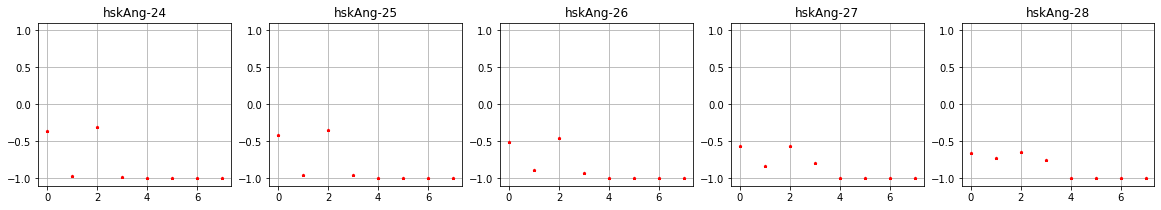

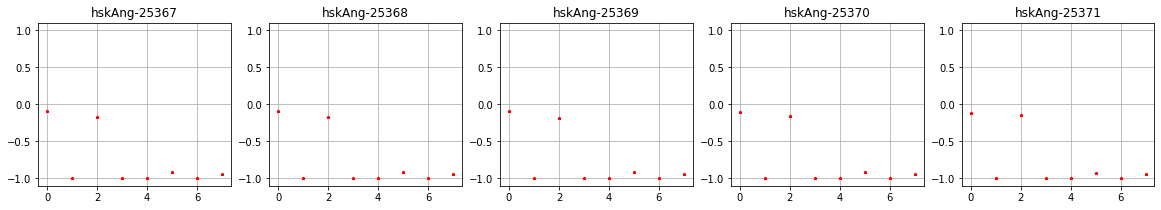

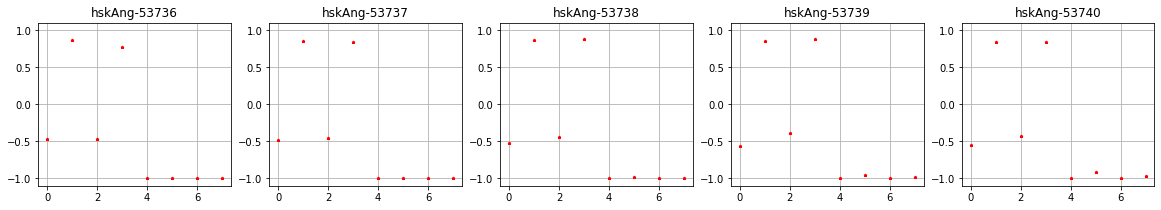

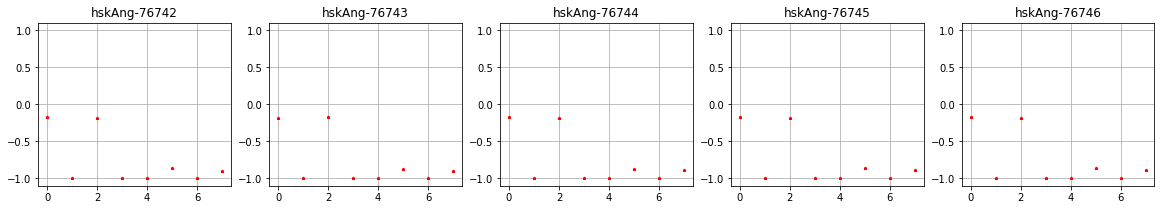

In [ ]:
n0, n1, n2 = 24, 5, unique.shape[0]
for i in range(n2):
  hskAngPlot(angleFillXBodyNeck, [], [], 0.1, sum(counts[0:i])+n0, n1)

In [ ]:
nanlst = checkNaNData(angleFillXBodyNeck)
print(nanlst)  

[]


In [ ]:
# dropFillXBody catgrDropY

## Multiframe data setup

In [31]:
np.set_printoptions(linewidth=180, precision=2)
j, frames = 0, 5
tmp = fillXBodyNeck.iloc[j:j+frames,:].values
print(tmp)
print(tmp.shape)
rtmp = tmp.reshape(1,-1)
print(rtmp)
print(rtmp.reshape(-1, 2*nBHSK))

[[0.5  0.38 0.5  0.5  0.44 0.5  0.37 0.46 0.36 0.32 0.56 0.5  0.64 0.44 0.68 0.31 0.46 0.75 0.37 0.9  0.41 0.98 0.56 0.74 0.65 0.91 0.61 0.98]
 [0.5  0.38 0.5  0.5  0.44 0.5  0.37 0.45 0.36 0.31 0.56 0.5  0.64 0.44 0.67 0.31 0.46 0.74 0.37 0.9  0.41 0.98 0.56 0.74 0.65 0.91 0.61 0.98]
 [0.49 0.38 0.5  0.5  0.44 0.5  0.37 0.45 0.36 0.31 0.56 0.5  0.64 0.44 0.67 0.31 0.46 0.74 0.37 0.9  0.41 0.98 0.56 0.74 0.66 0.91 0.6  0.97]
 [0.49 0.38 0.5  0.5  0.44 0.5  0.37 0.45 0.36 0.31 0.56 0.5  0.64 0.44 0.67 0.31 0.46 0.74 0.37 0.9  0.41 0.98 0.56 0.74 0.65 0.91 0.6  0.98]
 [0.49 0.38 0.5  0.5  0.44 0.5  0.37 0.45 0.36 0.31 0.56 0.5  0.64 0.44 0.68 0.31 0.46 0.75 0.37 0.9  0.41 0.98 0.56 0.74 0.66 0.91 0.6  0.98]]
(5, 28)
[[0.5  0.38 0.5  0.5  0.44 0.5  0.37 0.46 0.36 0.32 0.56 0.5  0.64 0.44 0.68 0.31 0.46 0.75 0.37 0.9  0.41 0.98 0.56 0.74 0.65 0.91 0.61 0.98 0.5  0.38 0.5  0.5  0.44 0.5  0.37
  0.45 0.36 0.31 0.56 0.5  0.64 0.44 0.67 0.31 0.46 0.74 0.37 0.9  0.41 0.98 0.56 0.74 0.65 0.91 0.

In [32]:
print(counts, sum(counts))

[59638 25343 28369 23006  8619] 144975


In [33]:
mFillXBody, mCounts = multiFrameX(fillXBody, counts, frames)
mFillXBodyNeck, mCounts = multiFrameX(fillXBodyNeck, counts, frames)
mNormalFillXBodyNeck, mCounts = multiFrameX(normalFillXBodyNeck, counts, frames)

In [34]:
#size = mFillXBody.shape

In [35]:
print(mCounts)
print(len(mNormalFillXBodyNeck))
# print(mNormalFillXBodyNeck)
# [939 522 501 427 117] frames=4

[59634 25339 28365 23002  8615]
144955


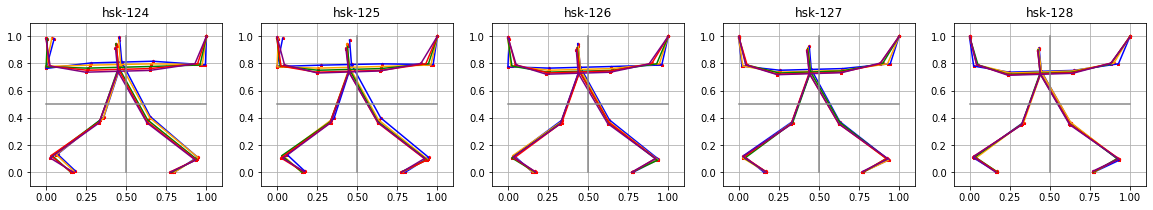

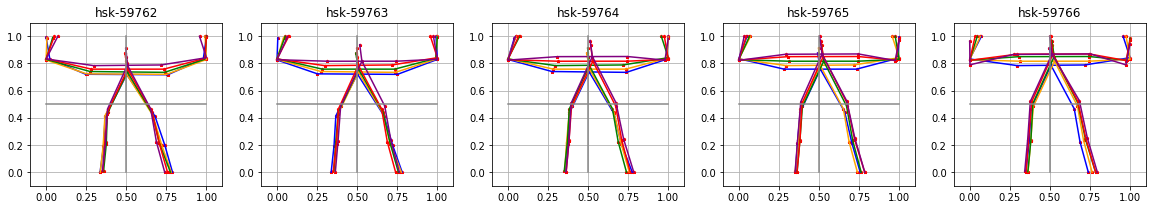

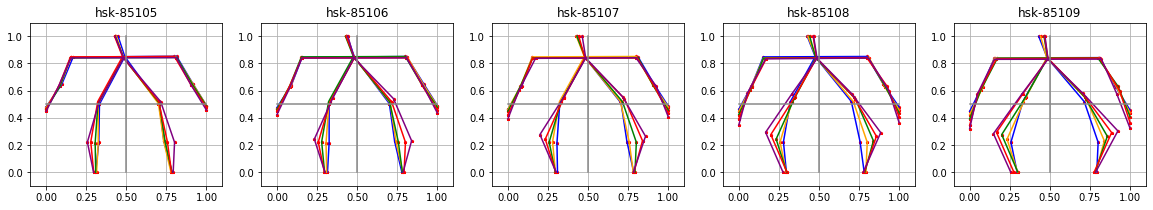

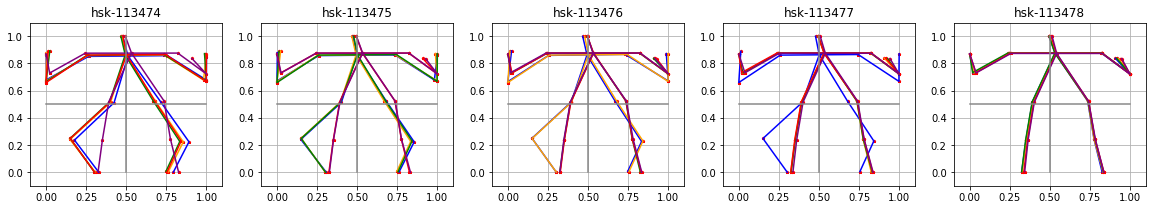

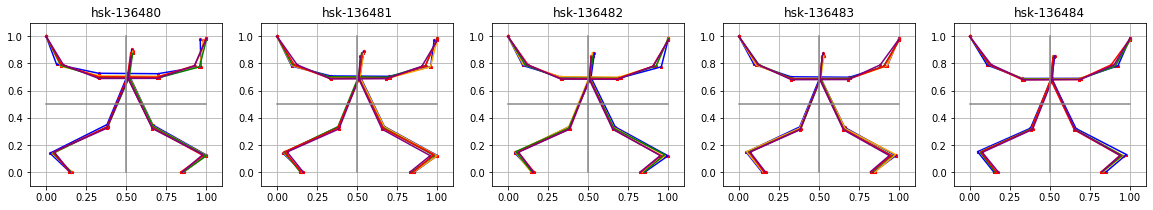

In [36]:
n0, n1, n2 = 124, 5, uniqueNum
for i in range(n2):
  hskPlot(mNormalFillXBodyNeck, [], [], nBHSK, frames, 0.1, sum(counts[0:i])+n0, n1) #[ 744  722  815 1008  811]

In [38]:
mCatgrY = catgr(mCounts) 
print(len(mCatgrY))
print(mCatgrY)

144955
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


## Split train and test data 

In [39]:
#train test split
# X_train, X_test, Y_train, Y_test = train_test_split(X, catgrY, test_size=0.1, random_state=9)
# X_train, X_test, Y_train, Y_test = train_test_split(fillXBody, catgrY, test_size=0.1, random_state=9)
# X_train, X_test, Y_train, Y_test = train_test_split(mFillXBody, mCatgrY, test_size=0.1, random_state=9)
# X_train, X_test, Y_train, Y_test = train_test_split(fillXBodyNeck, catgrY, test_size=0.1, random_state=9)
# X_train, X_test, Y_train, Y_test = train_test_split(mFillXBodyNeck, mCatgrY, test_size=0.1, random_state=9)
# X_train, X_test, Y_train, Y_test = train_test_split(normalFillXBodyNeck, catgrY, test_size=0.1, random_state=9)
X_train, X_test, Y_train, Y_test = train_test_split(mNormalFillXBodyNeck, mCatgrY, test_size=0.2, random_state=9)
# X_train, X_test, Y_train, Y_test = train_test_split(angleFillXBodyNeck, catgrY, test_size=0.1, random_state=9)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(115964, 140) (115964, 5)
(28991, 140) (28991, 5)


In [40]:
print(X_train.head(n))
print(X_train.tail(n))

             0         1         2         3         4         5         6         7         8    \
114196  0.520795  0.000000  0.539419  0.135940  0.276358  0.136310  0.000000  0.275661  0.041109   
14004   0.522471  0.094447  0.518551  0.275378  0.348168  0.276017  0.145190  0.178209  0.000000   
43319   0.483384  0.082594  0.494755  0.257798  0.300614  0.259366  0.075716  0.223404  0.000000   
54867   0.503463  0.076966  0.483814  0.245879  0.300406  0.248827  0.159478  0.400695  0.068774   
104708  0.483213  0.000000  0.532109  0.149035  0.199587  0.160032  0.119649  0.577373  0.000000   

             9         10        11        12        13       14        15        16        17   \
114196  0.108421  0.802479  0.135571  1.000000  0.272710  0.98849  0.145813  0.399035  0.488472   
14004   0.002190  0.688934  0.274740  0.879746  0.178296  1.00000  0.000000  0.395282  0.661247   
43319   0.012333  0.688896  0.256231  0.928803  0.207442  1.00000  0.000000  0.365418  0.625416   
548

In [41]:
print(Y_train.shape)
print(Y_train)
print(Y_test.shape)
print(Y_test)

(115964, 5)
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(28991, 5)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]



# FNN Keras Model Section

## Keras model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 140)               0         
                                                                 
 dropout (Dropout)           (None, 140)               0         
                                                                 
 dense (Dense)               (None, 128)               18048     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 85)                10965     
                                                                 
 dropout_2 (Dropout)         (None, 85)                0         
                                                                 
 dense_2 (Dense)             (None, 56)                4

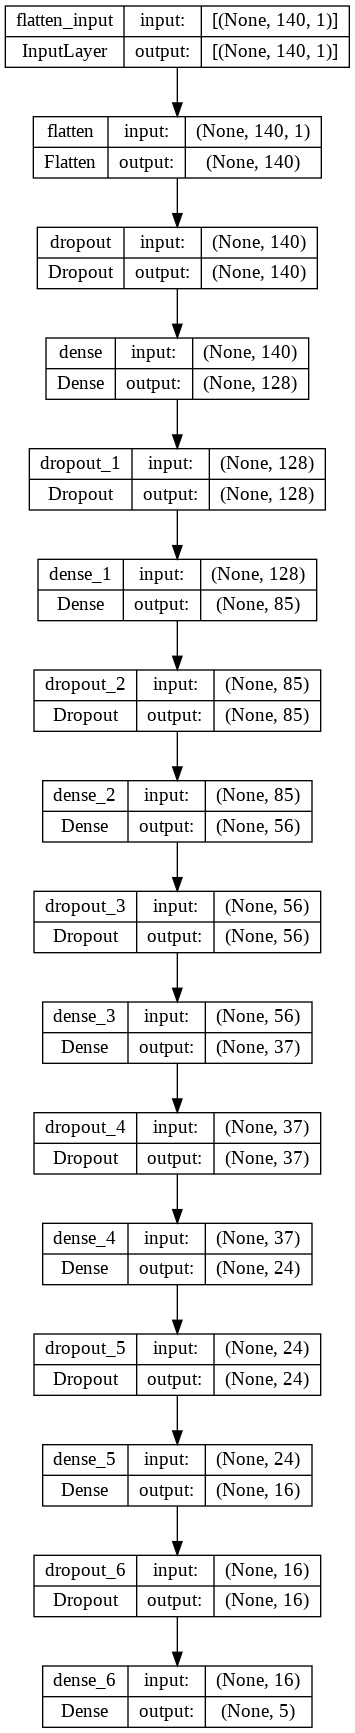

In [42]:
nodeNum = iniNodeNum = 128 # Hidden layer node # 32 64 128 256 # 128
layerNum = 6 # Hidden layer # 10 3 # 6
rfactor = 2/3 # 1/2
dropNum = 0.01 # Drop out Num 0.01
regularizerNum = 0
patienceNum = 250 #PatienceNum = EpochNum
act_hid_fn = 'relu' # relu tanh, sigmoid
act_out_fn = 'sigmoid'
opti_fn = 'adam'
opt = keras.optimizers.Adam(learning_rate=0.001)
loss_fn ='mae' # 'mae', mse' 'logcosh'

# case_name = 'FNN__no'+str(nodeNum)+'_la'+str(layerNum)+'_'+act_hid_fn+'_'+act_out_fn+'_'+opti_fn
model_path = myPath + 'log/har_' + '{epoch:02d}_{val_loss:.4f}.hdf5'

# To save model during learning process
cb_checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
# To check best model
cb_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patienceNum)
# To make model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[X_train.shape[1], 1]))
model.add(keras.layers.Dropout(rate=dropNum))
for i in range(layerNum):
  model.add(keras.layers.Dense(nodeNum, activation=act_hid_fn))
#  model.add(keras.layers.Dense(nodeNum, kernel_regularizer=keras.regularizers.l2(regularizerNum), activation=act_hid_fn))
  model.add(keras.layers.Dropout(rate=dropNum))
  nodeNum = (int)(nodeNum*rfactor)
model.add(keras.layers.Dense(Y_train.shape[1])) #, activation=act_out_fn

model.compile(optimizer = opt, loss = loss_fn, metrics=['mse']) # mae --> mse // opti_fn
model.layers
model.summary()
keras.utils.plot_model(model, myPath+"log/model_configuration.png", show_shapes=True)

## Model fitting

In [43]:
reset_weights(model)
# mNormalFillXBodyNeck, mCatgrY : batchNum = 50, epochNum = 2000, learning_rate=0.0005, loss: 0.0069 - mse: 0.0023 - val_loss: 0.0076 - val_mse: 0.0011
# angleFillXBodyNeck, catgrY : batchNum = 30, epochNum = 2000, learning_rate=0.00009, 
# batchNum = 26, learning_rate=0.00009, decay=0.0001 

In [44]:
reset_weights(model)
batchNum = 50 # Batch num 200
epochNum = 500 # EpochNum 300
loss_fn ='mae' # 'mae', mse' 'logcosh'
learning_rate = 0.0001
opt = keras.optimizers.Adam(learning_rate=learning_rate) # 0.0002
model.compile(optimizer = opt, loss = loss_fn, metrics=['mse'])
history = model.fit(X_train, Y_train, epochs=epochNum, batch_size=batchNum, 
  validation_data = (X_test, Y_test), callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/500
2313/2320 [============================>.] - ETA: 0s - loss: 0.1674 - mse: 0.1520
Epoch 1: val_loss improved from inf to 0.09936, saving model to /content/drive/MyDrive/Proposal/SIIF2021/DeepLearning/log/har_01_0.0994.hdf5
2320/2320 [==============================] - 11s 4ms/step - loss: 0.1672 - mse: 0.1519 - val_loss: 0.0994 - val_mse: 0.0868
Epoch 2/500
2309/2320 [============================>.] - ETA: 0s - loss: 0.1011 - mse: 0.0825
Epoch 2: val_loss improved from 0.09936 to 0.07736, saving model to /content/drive/MyDrive/Proposal/SIIF2021/DeepLearning/log/har_02_0.0774.hdf5
2320/2320 [==============================] - 8s 4ms/step - loss: 0.1010 - mse: 0.0824 - val_loss: 0.0774 - val_mse: 0.0621
Epoch 3/500
2308/2320 [============================>.] - ETA: 0s - loss: 0.0790 - mse: 0.0604
Epoch 3: val_loss improved from 0.07736 to 0.06672, saving model to /content/drive/MyDrive/Proposal/SIIF2021/DeepLearning/log/har_03_0.0667.hdf5
2320/2320 [=============================

In [45]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = myPath+'log/history.csv'
with open(hist_csv_file, mode='w') as f:
  hist_df.to_csv(f)

## Plot: learning curve

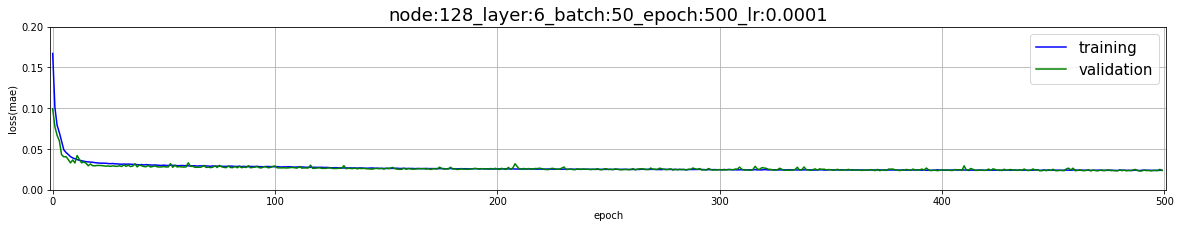

In [46]:
title = 'node:'+str(iniNodeNum)+'_layer:'+str(layerNum)+'_batch:'+str(batchNum)+'_epoch:'+str(epochNum)+'_lr:'+str(learning_rate) 
plt.plot(pd.DataFrame(history.history)[['loss']], 'b', label='training')
plt.plot(pd.DataFrame(history.history)[['val_loss']], 'g', label='validation')
# plt.figure(figsize=(5,5), dpi=10000, facecolor='w', edgecolor='k')
plt.xlabel("epoch")
plt.ylabel("loss(mae)")  # "Loss(MAE)"  logcosh
plt.rcParams['figure.figsize'] = [15, 6]
font = {'weight' : 'normal', 'size' : 15}
plt.rc('font', **font)
plt.title(title) 
plt.grid(True)
plt.legend()
plt.xlim(-1, epochNum+1)
plt.ylim(0, 0.2)
plt.savefig(myPath+'log/_LearningCurve_'+title+'.png', dpi=300)
plt.show()

In [47]:
predict_train = model.predict(X_train)
train_targets = Y_train
train_mae_score, train_mse_score = model.evaluate(X_train, Y_train)
predict_test = model.predict(X_test)
test_targets = Y_test
test_mae_score, test_mse_score = model.evaluate(X_test, Y_test)

906/906 [==============================] - 2s 2ms/step - loss: 0.0236 - mse: 0.0203


In [48]:
predict_train_index = np.argmax(predict_train, axis=1)
train_targets_index = np.argmax(train_targets, axis=1)
print(predict_train_index)
print(train_targets_index)
predict_train_diff = abs(train_targets_index-predict_train_index)
predict_train_false = np.where(predict_train_diff>0, 1, 0)
print(predict_train_false, sum(predict_train_false), predict_train_false.shape[0])

[3 0 0 ... 2 0 2]
[3 0 0 ... 2 0 2]
[0 0 0 ... 0 0 0] 4986 115964


In [49]:
predict_test_index = np.argmax(predict_test, axis=1)
test_targets_index = np.argmax(test_targets, axis=1)
print(predict_test_index)
print(test_targets_index)
predict_test_diff = abs(test_targets_index-predict_test_index)
predict_test_false = np.where(predict_test_diff>0, 1, 0)
print(predict_test_false, sum(predict_test_false), predict_test_false.shape[0])

[0 1 0 ... 0 1 1]
[0 1 0 ... 0 1 4]
[0 0 0 ... 0 0 1] 1323 28991


## Plot: train and test prediction

In [50]:
n0, n1 = 0, 15
print(np.array_str(predict_train[n0:n1,:], precision=2, suppress_small=True))
print(np.array_str(train_targets[n0:n1,:], precision=2, suppress_small=True))

[[-0.    0.    0.    0.99  0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.   -0.    0.99  0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [-0.    0.    0.    0.99  0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.    0.99  0.    0.    0.  ]
 [-0.    0.    0.    0.99  0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.   -0.    0.    0.    0.09]
 [-0.    0.    0.    0.99  0.  ]]
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [51]:
print(np.array_str(predict_test[n0:n1,:], precision=2, suppress_small=True))
print(np.array_str(test_targets[n0:n1,:], precision=2, suppress_small=True))

[[ 0.98 -0.    0.    0.    0.  ]
 [ 0.    0.99  0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [-0.    0.    0.    0.99  0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.    0.99  0.    0.    0.  ]
 [ 0.   -0.    0.99  0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]
 [ 0.98 -0.    0.    0.    0.  ]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [52]:
diff_train = abs(predict_train - train_targets)
diff_test = abs(predict_test - test_targets)
print(np.array_str(diff_train[n0:n1,:], precision=2, suppress_small=True))
print(np.array_str(diff_test[n0:n1,:], precision=2, suppress_small=True))

[[0.   0.   0.   0.01 0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.91]
 [0.   0.   0.   0.01 0.  ]]
[[0.02 0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.  ]
 [0.02 0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.  ]]


In [53]:
error_train = np.linalg.norm(diff_train, axis=1)
error_test = np.linalg.norm(diff_test, axis=1)
print(np.array_str(error_train[n0:n1], precision=2, suppress_small=True))
print(np.array_str(error_test[n0:n1], precision=2, suppress_small=True))

[0.01 0.02 0.02 0.02 0.01 0.02 0.01 0.02 0.02 0.02 0.01 0.01 0.02 0.91 0.01]
[0.02 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.02 0.01 0.01 0.02 0.02]


In [54]:
threshold = 0.5
train_false = np.where(error_train>threshold, 1, 0)
print(train_false, sum(train_false), error_train.shape[0])
train_false_index = np.argwhere(error_train>threshold)
print(train_false_index.T)

[0 0 0 ... 0 0 0] 7213 115964
[[    13     42     53 ... 115887 115910 115939]]


In [55]:
test_false = np.where(error_test>threshold, 1, 0)
print(test_false, sum(test_false), error_test.shape[0])
test_false_index = np.argwhere(error_test>threshold)
print(test_false_index.T)

[0 0 0 ... 0 0 1] 1851 28991
[[   21    29    44 ... 28950 28983 28990]]


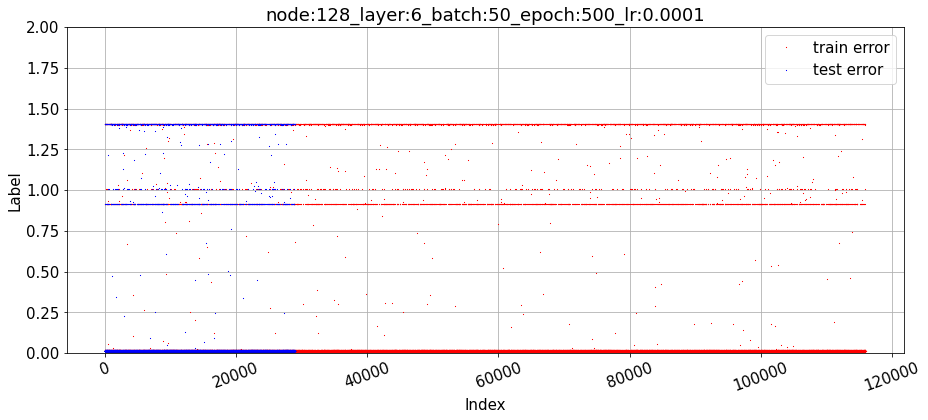

In [56]:
n0, n1, n2 = 0, error_train.shape[0], error_test.shape[0]
#n0, n1, n2 = 10000, 20000, error_test.shape[0] #error_train.shape[0], 
plt.plot(error_train[n0:n1], 'r*', label='train error', markersize=0.5)
plt.plot(error_test[n0:n1], 'b*', label='test error', markersize=0.5)
plt.title(title)
plt.ylim(0, 2)
plt.ylabel('Label')
plt.xlabel('Index')
plt.xticks(rotation=20)
plt.rcParams['figure.figsize'] = [15, 6]
plt.grid(True)
plt.legend()
plt.savefig(myPath+'log/_timeseries'+title+'.png', dpi=300)
plt.show()

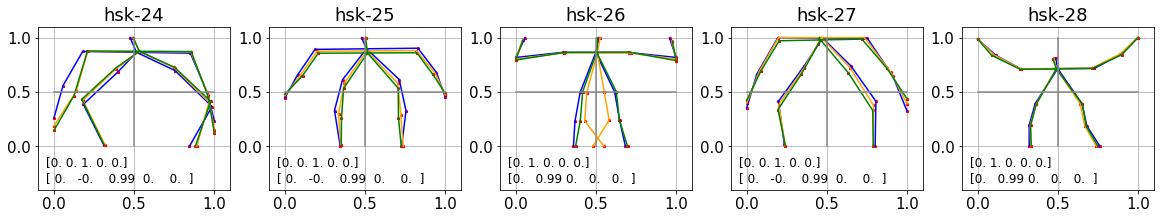

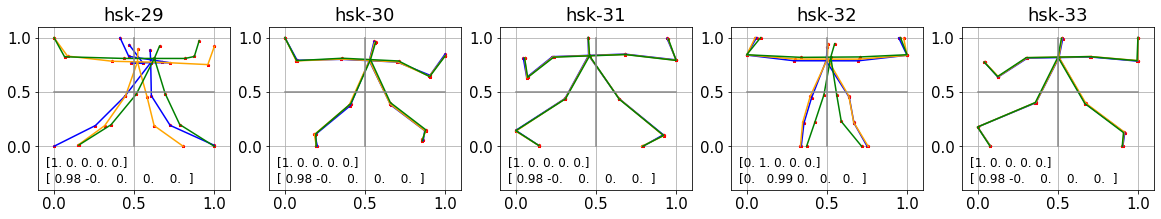

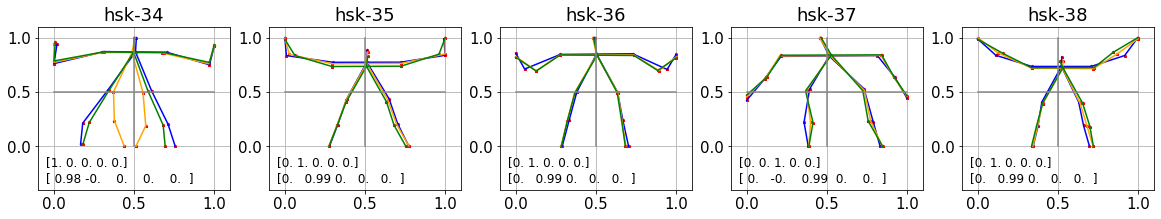

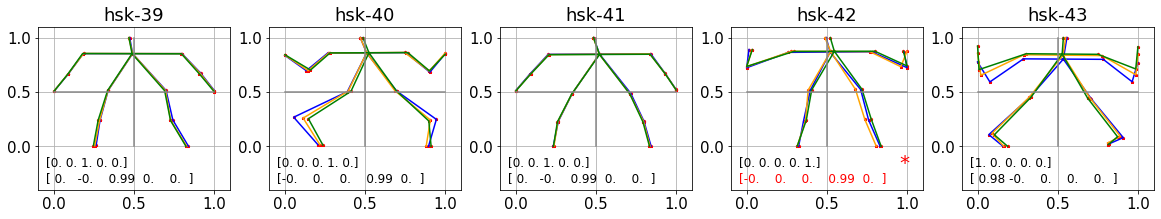

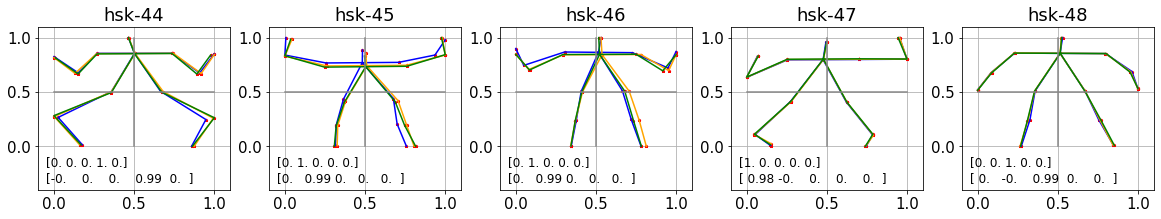

In [57]:
## diff = abs(Y[i+j,:] - pY[i+j,:])
## if np.linalg.norm(diff) > 0.5: max sqrt(2)
n0, n1, n2 = 24, 5, unique.shape[0]
for i in range(n2):
  hskPlot(X_train, train_targets, predict_train, nBHSK, 3, 0.1, n0+i*n1, n1)
#  hskAngPlot(X_train, train_targets, predict_train, 0.1, n0+i*n1, n1)

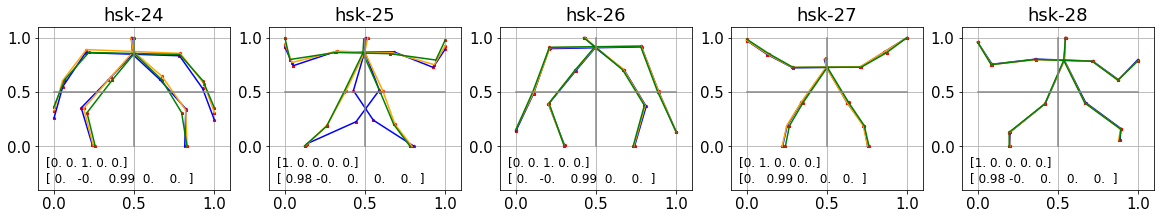

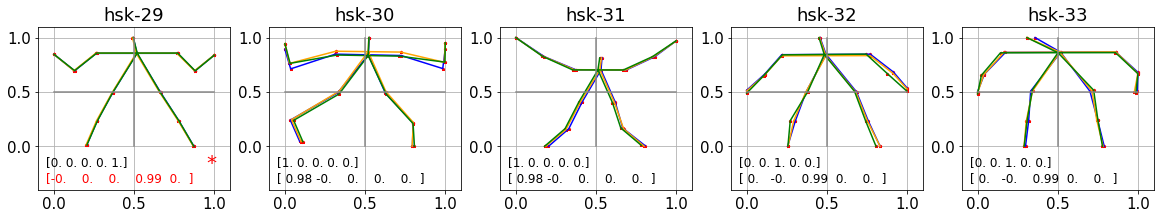

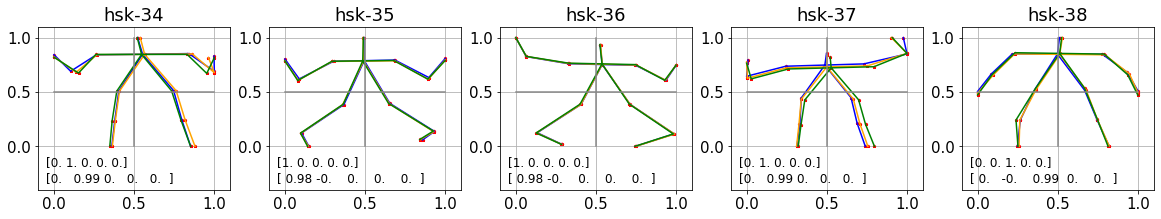

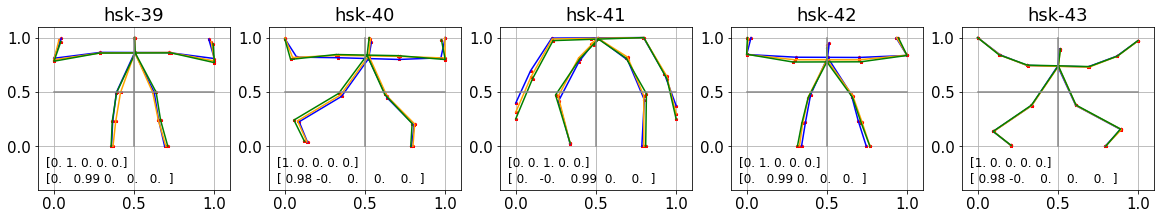

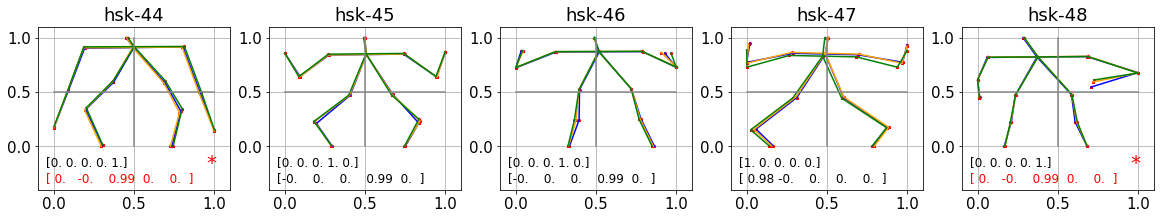

In [ ]:
n0, n1, n2 = 24, 5, unique.shape[0]
for i in range(n2):
  hskPlot(X_test, test_targets, predict_test, nBHSK, 3, 0.1, n0+i*n1, n1)
#  hskAngPlot(X_train, train_targets, predict_train, 0.1, n0+i*n1, n1)

## Load best model

In [58]:
model_list = os.listdir(myPath+'log/')
model_list = list(filter(lambda k: 'har' in k, model_list))
print(model_list)

['har_01_0.0994.hdf5', 'har_02_0.0774.hdf5', 'har_03_0.0667.hdf5', 'har_04_0.0601.hdf5', 'har_05_0.0430.hdf5', 'har_06_0.0404.hdf5', 'har_08_0.0371.hdf5', 'har_09_0.0330.hdf5', 'har_11_0.0329.hdf5', 'har_16_0.0326.hdf5', 'har_17_0.0295.hdf5', 'har_20_0.0294.hdf5', 'har_24_0.0293.hdf5', 'har_25_0.0290.hdf5', 'har_27_0.0287.hdf5', 'har_30_0.0287.hdf5', 'har_32_0.0286.hdf5', 'har_36_0.0285.hdf5', 'har_39_0.0281.hdf5', 'har_45_0.0279.hdf5', 'har_55_0.0276.hdf5', 'har_65_0.0275.hdf5', 'har_70_0.0274.hdf5', 'har_72_0.0272.hdf5', 'har_79_0.0271.hdf5', 'har_84_0.0270.hdf5', 'har_90_0.0270.hdf5', 'har_94_0.0270.hdf5', 'har_95_0.0269.hdf5', 'har_103_0.0269.hdf5', 'har_104_0.0269.hdf5', 'har_106_0.0267.hdf5', 'har_111_0.0266.hdf5', 'har_118_0.0262.hdf5', 'har_127_0.0261.hdf5', 'har_128_0.0261.hdf5', 'har_133_0.0259.hdf5', 'har_138_0.0257.hdf5', 'har_144_0.0255.hdf5', 'har_145_0.0253.hdf5', 'har_156_0.0253.hdf5', 'har_157_0.0251.hdf5', 'har_171_0.0250.hdf5', 'har_183_0.0249.hdf5', 'har_223_0.0249.

In [59]:
maxNum=0
for ii in range(len(model_list)):
    if len(model_list[ii].split('_'))>1:
        if int(model_list[ii].split('_')[1])>= maxNum:
            maxNum= int(model_list[ii].split('_')[1])
            maxIdx = ii
model_list[maxIdx]

model_load_path = myPath+'log/'+model_list[maxIdx]
print(model_load_path)

/content/drive/MyDrive/Proposal/SIIF2021/DeepLearning/log/har_490_0.0230.hdf5


In [60]:
best_model = keras.models.load_model(model_load_path)
weights = best_model.get_weights()
print(weights)

[array([[ 0.09,  0.01, -0.09, ...,  0.2 ,  0.13, -0.02],
       [ 0.41,  0.04, -0.05, ..., -0.28, -0.16, -0.32],
       [ 0.1 ,  0.01, -0.09, ...,  0.07,  0.02, -0.03],
       ...,
       [ 0.03,  0.13,  0.07, ..., -0.07,  0.08,  0.18],
       [-0.03,  0.  , -0.13, ...,  0.17,  0.  , -0.09],
       [-0.08, -0.05, -0.12, ...,  0.08,  0.04, -0.05]], dtype=float32), array([-0.11,  0.09,  0.1 , -0.03, -0.  ,  0.01,  0.02,  0.06, -0.04,  0.06,  0.06,  0.01,  0.06,  0.09, -0.02, -0.06,  0.09,  0.03, -0.01,  0.11,  0.12, -0.01,  0.03,  0.09,
        0.02, -0.04, -0.05,  0.07, -0.03, -0.07, -0.03, -0.04, -0.05, -0.03, -0.01,  0.1 ,  0.11,  0.04,  0.  ,  0.02, -0.11, -0.05, -0.02, -0.04, -0.03, -0.  , -0.05,  0.03,
        0.01,  0.09,  0.03, -0.01,  0.06, -0.01,  0.11, -0.01,  0.11,  0.08,  0.04, -0.02, -0.01,  0.03, -0.12,  0.09, -0.02, -0.09, -0.04, -0.14,  0.06,  0.1 ,  0.06,  0.04,
       -0.06, -0.  , -0.02,  0.04, -0.06,  0.07,  0.05, -0.01, -0.09,  0.09, -0.1 ,  0.03, -0.01, -0.  , -0.0

## Keras.sequence weights

In [61]:
def relu(X):
  return np.maximum(0,X)

In [62]:
weights = model.get_weights()
print(weights)

[array([[ 0.09,  0.02, -0.09, ...,  0.2 ,  0.13, -0.02],
       [ 0.4 ,  0.06, -0.04, ..., -0.29, -0.17, -0.33],
       [ 0.1 ,  0.01, -0.09, ...,  0.06,  0.02, -0.03],
       ...,
       [ 0.03,  0.13,  0.07, ..., -0.08,  0.08,  0.17],
       [-0.04,  0.  , -0.13, ...,  0.17,  0.  , -0.08],
       [-0.07, -0.05, -0.12, ...,  0.08,  0.04, -0.04]], dtype=float32), array([-0.11,  0.1 ,  0.1 , -0.04, -0.  ,  0.01,  0.02,  0.06, -0.04,  0.06,  0.07,  0.01,  0.06,  0.1 , -0.02, -0.06,  0.09,  0.02, -0.01,  0.11,  0.12, -0.01,  0.03,  0.09,
        0.02, -0.04, -0.05,  0.07, -0.03, -0.07, -0.03, -0.04, -0.04, -0.03, -0.01,  0.1 ,  0.11,  0.03,  0.  ,  0.03, -0.11, -0.05, -0.02, -0.04, -0.03,  0.  , -0.05,  0.03,
        0.01,  0.09,  0.02, -0.01,  0.06, -0.01,  0.11, -0.01,  0.11,  0.08,  0.04, -0.02, -0.01,  0.03, -0.13,  0.09, -0.02, -0.09, -0.04, -0.14,  0.06,  0.1 ,  0.06,  0.04,
       -0.06, -0.  , -0.02,  0.04, -0.06,  0.07,  0.05, -0.01, -0.09,  0.09, -0.1 ,  0.04, -0.01, -0.01, -0.0

In [63]:
print(weights[0].shape)
print(np.array_str(weights[0], precision=2, suppress_small=True))

(140, 128)
[[ 0.09  0.02 -0.09 ...  0.2   0.13 -0.02]
 [ 0.4   0.06 -0.04 ... -0.29 -0.17 -0.33]
 [ 0.1   0.01 -0.09 ...  0.06  0.02 -0.03]
 ...
 [ 0.03  0.13  0.07 ... -0.08  0.08  0.17]
 [-0.04  0.   -0.13 ...  0.17  0.   -0.08]
 [-0.07 -0.05 -0.12 ...  0.08  0.04 -0.04]]


In [64]:
print(weights[1].shape)
print(np.array_str(weights[1], precision=2, suppress_small=True))

(128,)
[-0.11  0.1   0.1  -0.04 -0.    0.01  0.02  0.06 -0.04  0.06  0.07  0.01  0.06  0.1  -0.02 -0.06  0.09  0.02 -0.01  0.11  0.12 -0.01  0.03  0.09  0.02 -0.04 -0.05  0.07 -0.03
 -0.07 -0.03 -0.04 -0.04 -0.03 -0.01  0.1   0.11  0.03  0.    0.03 -0.11 -0.05 -0.02 -0.04 -0.03  0.   -0.05  0.03  0.01  0.09  0.02 -0.01  0.06 -0.01  0.11 -0.01  0.11  0.08
  0.04 -0.02 -0.01  0.03 -0.13  0.09 -0.02 -0.09 -0.04 -0.14  0.06  0.1   0.06  0.04 -0.06 -0.   -0.02  0.04 -0.06  0.07  0.05 -0.01 -0.09  0.09 -0.1   0.04 -0.01 -0.01 -0.06
  0.   -0.01 -0.01 -0.02  0.08  0.03 -0.07  0.06 -0.07 -0.04  0.12  0.03 -0.01  0.13 -0.18  0.01  0.01 -0.15 -0.08  0.03  0.1   0.08  0.01 -0.1   0.    0.07  0.05 -0.01 -0.01
  0.07 -0.1   0.    0.    0.02  0.13  0.03 -0.06  0.   -0.07 -0.09  0.03]


In [65]:
x = X_test.iloc[1,:]
l0=np.matmul(x, weights[0])
print(l0.shape)
print(np.array_str(l0, precision=2, suppress_small=True))

(128,)
[ 1.16 -0.78 -0.51 -0.56 -0.99 -0.39 -0.21 -0.42 -0.26 -2.67  0.92 -0.21 -0.8  -0.66 -0.51 -0.44 -0.39  0.53 -1.37 -0.15 -1.61 -0.61  0.23  0.45  0.13  0.55  0.12  0.15  0.16
  0.18 -0.97  0.33 -0.15  0.79  0.56 -1.67 -0.38  0.36 -1.27  0.39  0.09 -0.09  0.76  0.69 -2.55  0.01  0.13 -0.09 -0.22  1.23 -0.91 -0.75 -0.13  0.59 -1.85  0.34 -2.19 -1.46
 -1.21 -2.88 -0.72  0.94  0.51 -0.28 -0.93  0.1   0.37  0.84  0.61 -0.45 -1.54 -0.09  0.96 -0.63 -0.24 -0.46  0.29 -2.17 -1.31 -0.9  -0.04 -0.06 -0.19  0.23  0.71  0.21  0.81
 -1.37 -1.26  0.17 -2.63  0.11 -0.28  0.43  0.24  0.23  0.78  0.23 -0.27 -0.98 -1.16  0.95  1.07  1.19  0.38  0.23 -0.09 -0.43 -1.27  0.75  0.17  0.7  -1.19 -0.03 -0.31 -0.96
  0.26  0.11 -0.99 -0.45  0.06  0.72 -3.04 -0.58 -1.13  0.05  0.54 -0.3 ]


In [66]:
l0=l0+weights[1]
print(np.array_str(l0, precision=2, suppress_small=True))

[ 1.05 -0.68 -0.41 -0.6  -1.   -0.38 -0.19 -0.36 -0.3  -2.61  0.99 -0.2  -0.74 -0.57 -0.53 -0.5  -0.3   0.55 -1.39 -0.04 -1.49 -0.61  0.26  0.54  0.15  0.51  0.07  0.23  0.13
  0.11 -1.    0.29 -0.2   0.76  0.55 -1.57 -0.27  0.4  -1.27  0.42 -0.02 -0.14  0.74  0.66 -2.58  0.01  0.08 -0.05 -0.21  1.32 -0.88 -0.76 -0.07  0.58 -1.74  0.33 -2.08 -1.38
 -1.16 -2.89 -0.73  0.97  0.38 -0.19 -0.94  0.01  0.33  0.7   0.67 -0.35 -1.48 -0.05  0.9  -0.63 -0.25 -0.42  0.24 -2.1  -1.26 -0.91 -0.13  0.03 -0.3   0.27  0.7   0.21  0.75
 -1.37 -1.28  0.16 -2.65  0.18 -0.24  0.36  0.3   0.16  0.74  0.36 -0.24 -0.99 -1.03  0.77  1.09  1.2   0.23  0.15 -0.07 -0.33 -1.2   0.76  0.07  0.7  -1.11  0.02 -0.32 -0.97
  0.32  0.01 -0.99 -0.44  0.08  0.84 -3.01 -0.65 -1.13 -0.01  0.46 -0.27]


In [67]:
l00=relu(l0)
print(np.array_str(l00, precision=2, suppress_small=True))

[1.05 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.55 0.   0.   0.   0.   0.26 0.54 0.15 0.51 0.07 0.23 0.13 0.11 0.   0.29 0.   0.76 0.55
 0.   0.   0.4  0.   0.42 0.   0.   0.74 0.66 0.   0.01 0.08 0.   0.   1.32 0.   0.   0.   0.58 0.   0.33 0.   0.   0.   0.   0.   0.97 0.38 0.   0.   0.01 0.33 0.7  0.67 0.
 0.   0.   0.9  0.   0.   0.   0.24 0.   0.   0.   0.   0.03 0.   0.27 0.7  0.21 0.75 0.   0.   0.16 0.   0.18 0.   0.36 0.3  0.16 0.74 0.36 0.   0.   0.   0.77 1.09 1.2  0.23
 0.15 0.   0.   0.   0.76 0.07 0.7  0.   0.02 0.   0.   0.32 0.01 0.   0.   0.08 0.84 0.   0.   0.   0.   0.46 0.  ]


In [68]:
l1=relu(np.matmul(l00, weights[2])+weights[3])
print(np.array_str(l1, precision=2, suppress_small=True))

[0.   0.49 0.   0.   0.   0.   0.   0.   0.   1.75 0.12 0.   0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.81 0.52 1.42 0.   0.   0.   0.   0.   0.   0.   0.   0.   1.15 0.
 0.41 0.   0.15 0.62 0.   0.   0.   0.24 0.24 0.15 2.76 0.   0.8  0.   0.   0.16 0.   0.6  1.72 0.   0.   0.   0.01 0.   0.66 0.   0.   0.65 0.   0.   0.   0.   0.12 0.   0.58
 0.   0.23 0.82 0.   0.   0.   0.46 1.49 0.   0.41 0.   0.   0.   0.94 0.  ]


In [69]:
l2=relu(np.matmul(l1, weights[4])+weights[5])
print(np.array_str(l2, precision=2, suppress_small=True))

[0.   0.   0.   0.   0.   0.   1.59 0.   0.65 0.   0.   0.   0.   0.   0.76 0.12 1.07 0.   0.   0.   0.   0.   0.   0.   0.   3.03 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.02 0.   0.   0.29 0.   0.45 0.   0.   0.   0.   0.   0.   0.   0.   0.   1.33 0.   0.  ]


In [70]:
l3=np.matmul(l2, weights[6])+weights[7]
print(np.array_str(l3, precision=5, suppress_small=True))

[ 0.5666  -1.58585 -0.56644 -1.15789  0.23111  0.83737 -1.09827  0.29841 -2.68981  0.44451  0.55613  0.04971 -2.01957 -1.03433 -3.61549 -2.00185 -1.08291 -1.14683 -2.38603
 -0.58747  0.88035  0.48422  0.19778  0.31757 -0.98686 -0.90557 -2.1358  -0.72067  0.16747 -4.54579 -0.07804 -0.55614  0.28367 -1.09383 -1.73391  0.0947   0.40101]


In [71]:
x = X_test.iloc[0,:]
predict_test = model.predict(X_test)
print(np.array_str(predict_test, precision=5, suppress_small=True))

906/906 [==============================] - 1s 2ms/step
[[ 0.9837  -0.       0.00002  0.00002  0.00138]
 [ 0.0004   0.98748  0.00002  0.00001  0.00107]
 [ 0.98385 -0.       0.00002  0.00002  0.00137]
 ...
 [ 0.98382 -0.       0.00002  0.00002  0.00137]
 [ 0.00039  0.98752  0.00002  0.00001  0.00106]
 [ 0.00037  0.98755  0.00002  0.00001  0.00105]]


In [72]:
# test_mse_score_best, test_mae_score_best = best_model.evaluate(X_test, Y_test)
# test_mae_score_best #test_mae_score_best test_mse_score_best
#b = best_model.evaluate(X_test, Y_test)
#test_mae_score_best = b[1]
#best_predict_targets = best_model.predict(X_test)
#best_predict_targets.shape
#test_mae_score_best #test_mse_score_best

## Exercise type & status

In [73]:
print(eCounts, sum(eCounts))

[59638 25343 28369 23006  8619] 144975


In [74]:
type=0
sIndex=0
for i in range(type):
  sIndex = sIndex+eCounts[i]
eIndex=eCounts[type]
print(sIndex, sIndex+eIndex)

0 59638


In [75]:
X = data.iloc[sIndex:sIndex+eIndex, 6:6+2*nHSK] 
Y = data.iloc[sIndex:sIndex+eIndex, 5] #4 운동종류 4가지 #5 운동상태  
print(X.shape)

(59638, 36)


In [76]:
data.iloc[sIndex:sIndex+eIndex, 0:6+2*nHSK].head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
3188,3188,0,0,0,0,0,0.499608,0.194749,0.502411,0.311852,0.438370,0.315280,0.371690,0.267655,0.365272,0.129593,0.566453,0.308425,0.643461,0.251285,0.678149,0.120000,0.465528,0.557754,0.374243,0.715248,0.415919,0.793255,0.560437,0.556006,0.657150,0.720429,0.608417,0.791140,0.486904,0.196360,0.512901,0.195353,0.471350,0.218275,0.526890,0.214617
3189,3189,1,0,1,0,0,0.499166,0.194622,0.502862,0.312471,0.438775,0.315769,0.371163,0.266813,0.367635,0.126572,0.566949,0.309174,0.643568,0.251620,0.677111,0.117891,0.466106,0.556981,0.374274,0.712596,0.413743,0.792577,0.561147,0.554856,0.657503,0.720101,0.608519,0.790808,0.486852,0.196804,0.512440,0.195705,0.471971,0.218642,0.526998,0.215435
3190,3190,2,0,2,0,0,0.498267,0.193123,0.503353,0.313394,0.439568,0.316857,0.374136,0.266334,0.367729,0.125109,0.567138,0.309931,0.644002,0.250841,0.678326,0.119097,0.466587,0.557024,0.374515,0.713046,0.413299,0.792211,0.561697,0.556046,0.659040,0.721427,0.607940,0.788345,0.486436,0.196328,0.511532,0.194569,0.472338,0.219164,0.527205,0.216234
3191,3191,3,0,3,0,0,0.498433,0.191813,0.503920,0.312557,0.440263,0.315961,0.375067,0.265360,0.367898,0.123764,0.567577,0.309153,0.643412,0.251193,0.678543,0.121077,0.466573,0.557014,0.374765,0.712630,0.412886,0.792801,0.561831,0.555870,0.658696,0.720309,0.608498,0.788170,0.486688,0.195486,0.511509,0.193438,0.472869,0.218323,0.527425,0.214609
3192,3192,4,0,4,0,0,0.498271,0.194894,0.503682,0.312306,0.440085,0.316024,0.375203,0.264890,0.367487,0.124397,0.567279,0.308587,0.642948,0.251647,0.678921,0.120131,0.466571,0.557316,0.374784,0.713116,0.412846,0.792096,0.561207,0.555793,0.659019,0.720568,0.607977,0.788724,0.486261,0.197610,0.511559,0.195652,0.472237,0.219397,0.526984,0.215564
3193,3193,5,0,5,0,0,0.498852,0.195398,0.503714,0.312031,0.439888,0.315390,0.375765,0.264832,0.368556,0.123402,0.567540,0.308672,0.642871,0.251231,0.677925,0.121994,0.466206,0.558613,0.374987,0.714327,0.414816,0.792034,0.561057,0.557122,0.657690,0.721337,0.608377,0.788621,0.487101,0.197867,0.512103,0.196013,0.472910,0.219510,0.527277,0.215828
3194,3194,6,0,6,0,0,0.499748,0.192391,0.504100,0.311878,0.440385,0.315167,0.376385,0.264673,0.368553,0.124869,0.567815,0.308588,0.643652,0.251651,0.677872,0.122362,0.466424,0.558049,0.374924,0.716056,0.415010,0.792221,0.561282,0.556492,0.657760,0.722503,0.609032,0.789735,0.487599,0.196010,0.512820,0.193791,0.472905,0.218715,0.527853,0.214172
3195,3195,7,0,7,0,0,0.500286,0.192544,0.504713,0.311644,0.441179,0.315047,0.377328,0.264893,0.369750,0.124274,0.568246,0.308240,0.643826,0.251867,0.677817,0.122900,0.467105,0.556801,0.374855,0.713578,0.414209,0.792967,0.561958,0.556177,0.657750,0.722830,0.608891,0.790055,0.487971,0.196227,0.513320,0.193842,0.473082,0.218961,0.528063,0.213997
3196,3196,8,0,8,0,0,0.500827,0.191721,0.504515,0.310536,0.440754,0.313986,0.376662,0.261841,0.370118,0.122226,0.568276,0.307086,0.642702,0.252269,0.674811,0.120141,0.466293,0.556675,0.374925,0.713216,0.413912,0.791313,0.561645,0.555863,0.657698,0.723622,0.608741,0.790525,0.488435,0.195945,0.513232,0.193675,0.473631,0.218789,0.527424,0.213727
3197,3197,9,0,9,0,0,0.500634,0.193779,0.504414,0.311058,0.440662,0.314467,0.376470,0.264008,0.368982,0.123498,0.568167,0.307649,0.642872,0.250746,0.675363,0.120004,0.465790,0.556596,0.375449,0.714170,0.414771,0.791352,0.560953,0.555494,0.657198,0.723013,0.608394,0.790632,0.488024,0.196480,0.513414,0.194838,0.473080,0.219133,0.527464,0.214327


# LSTM Keras Model Section

## LSTM Models
## Vanilla LSTM
A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

## Stacked LSTM
Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

## Multivariate LSTM Models

Multivariate time series data means data where there is more than one observation for each time step.

A problem may have two or more parallel input time series and an output time series that is dependent on the input time series.

The input time series are parallel because each series has an observation at the same time steps.

## Multiframe Data

In [ ]:
#mFillXBody = np.array(mlFillXBody).reshape((size[0], frames, 28))
#mFillXBodyNeck = np.array(mlFillXBodyNeck).reshape((size[0], frames, 28))
#mNormalFillXBodyNeck = np.array(mlNormalFillXBodyNeck).reshape((size[0], frames, 28))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(mNormalFillXBodyNeck, mCatgrY, test_size=0.2, random_state=9)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1992, 112) (1992, 5)
(499, 112) (499, 5)


In [ ]:
train_size = X_train.shape
test_size = X_test.shape

In [ ]:
mX_train = np.array(X_train).reshape((train_size[0], frames, 2*nBHSK))

In [ ]:
mX_test = np.array(X_test).reshape((test_size[0], frames, 2*nBHSK))

In [ ]:
print(mX_train[0])

[[0.48 0.   0.51 0.13 0.26 0.13 0.05 0.29 0.   0.13 0.76 0.13 0.96 0.3  1.   0.14 0.3  0.5  0.26 0.78 0.27 1.   0.62 0.5  0.71 0.77 0.75 1.  ]
 [0.48 0.   0.5  0.13 0.23 0.13 0.02 0.29 0.   0.13 0.77 0.13 0.95 0.3  1.   0.14 0.3  0.5  0.25 0.78 0.25 1.   0.62 0.5  0.7  0.77 0.73 1.  ]
 [0.5  0.   0.49 0.13 0.2  0.13 0.   0.29 0.   0.13 0.78 0.13 0.95 0.3  1.   0.15 0.29 0.5  0.24 0.78 0.25 1.   0.63 0.5  0.71 0.77 0.74 1.  ]
 [0.49 0.   0.48 0.13 0.2  0.13 0.01 0.29 0.   0.13 0.75 0.14 0.93 0.3  1.   0.15 0.3  0.5  0.25 0.78 0.25 1.   0.62 0.5  0.7  0.77 0.73 1.  ]]


In [ ]:
print(mX_train.shape)

(1992, 4, 28)


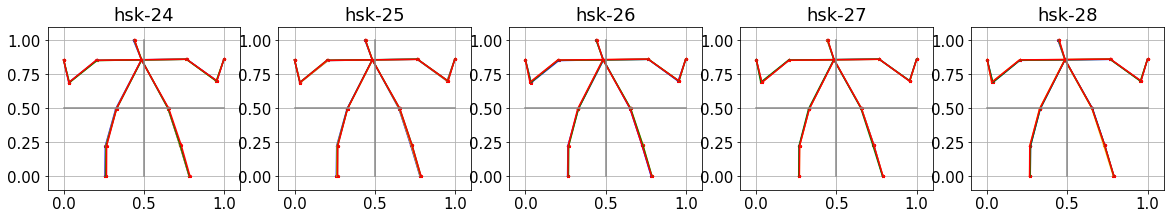

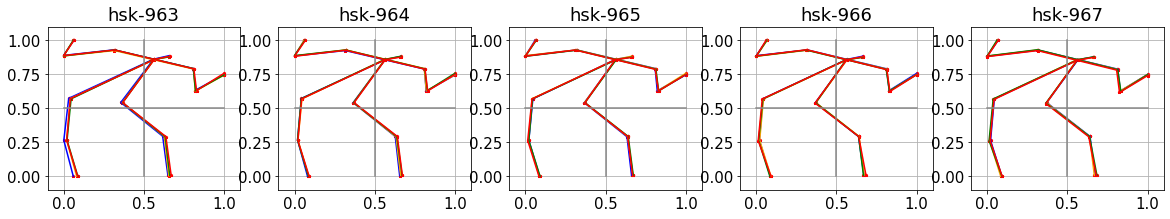

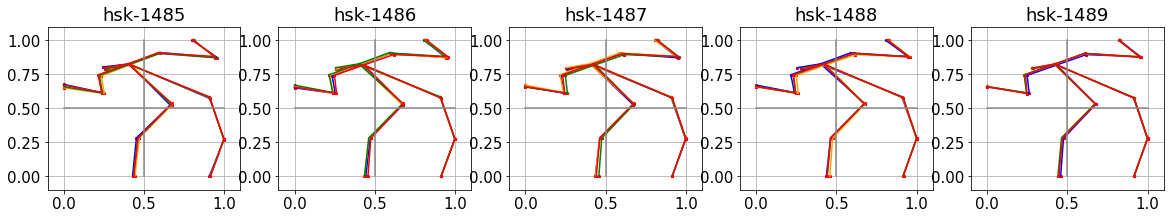

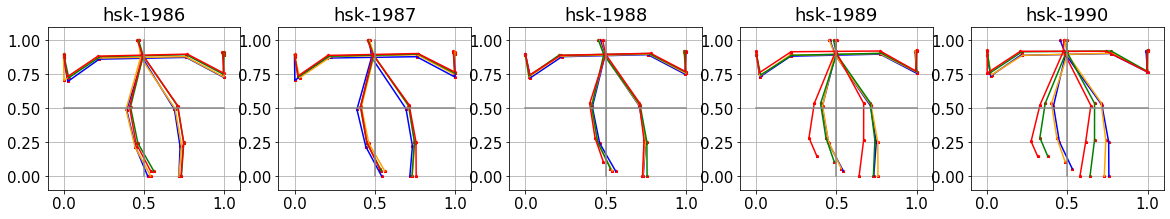

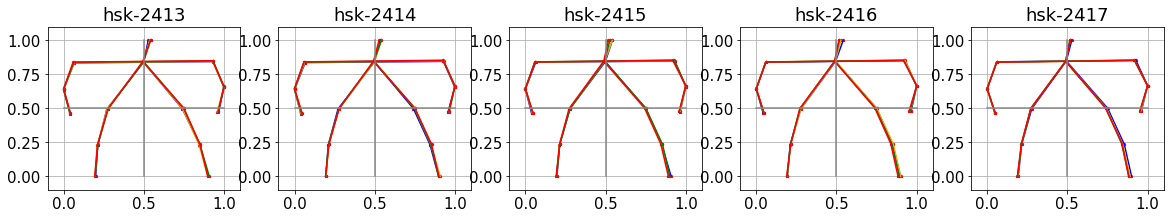

In [ ]:
n0, n1, n2 = 24, 5, 5
for i in range(n2):
  hskPlot(mNormalFillXBodyNeck, [], [], nBHSK, frames, 0.1, sum(counts[0:i])+n0, n1) #[ 744  722  815 1008  811]

## Keras model 

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_units = 64 # units: Positive integer, dimensionality of the output space. 96 3 , 64 4
n_stack = 4
n_steps = frames
n_features = 2*nBHSK
b_return = False
dropout = 0.05
if n_stack > 1:
  b_return = True
#X = mX_train.reshape((mX_train.shape[0], mX_train.shape[1], n_features)) # train_size (3268, 4, 28)

# define model
model = Sequential()
model.add(LSTM(n_units, activation='relu', return_sequences=b_return, input_shape=(n_steps, n_features)))
model.add(Dropout(dropout))
for i in range(n_stack-2):
  model.add(LSTM(n_units, activation='relu', return_sequences=b_return))
  model.add(Dropout(dropout))
if n_stack > 1:
  model.add(LSTM(n_units, activation='relu'))
  model.add(Dropout(dropout))
model.add(Dense(5))

model.layers
model.summary()
#model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 4, 64)             23808     
                                                                 
 dropout_44 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_17 (LSTM)              (None, 4, 64)             33024     
                                                                 
 dropout_45 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_18 (LSTM)              (None, 4, 64)             33024     
                                                                 
 dropout_46 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_19 (LSTM)              (None, 64)              

## Model fitting

In [ ]:
# fit model
reset_weights(model)
opt = tf.keras.optimizers.Adam(learning_rate=0.00025)
model.compile(optimizer=opt, loss='mse')
#model.compile(optimizer='adam', loss='mse')

history = model.fit(mX_train, Y_train, batch_size=50, epochs=2000, validation_data = (mX_test, Y_test), verbose=1)

#def scheduler(epoch):
#  if epoch < 10:
#    return 0.01
#  else:
#    return 0.001
#callback = LearningRateScheduler(scheduler)
#model.fit(X_train, Y_train, epochs=20, callbacks=[callback], verbose=1)

Epoch 1/2000
40/40 [==============================] - 6s 30ms/step - loss: 0.1941 - val_loss: 0.1848
Epoch 2/2000
40/40 [==============================] - 1s 14ms/step - loss: 0.1637 - val_loss: 0.1485
Epoch 3/2000
40/40 [==============================] - 1s 15ms/step - loss: 0.1475 - val_loss: 0.1425
Epoch 4/2000
40/40 [==============================] - 1s 15ms/step - loss: 0.1270 - val_loss: 0.0994
Epoch 5/2000
40/40 [==============================] - 1s 15ms/step - loss: 0.0889 - val_loss: 0.0710
Epoch 6/2000
40/40 [==============================] - 1s 15ms/step - loss: 0.0761 - val_loss: 0.0676
Epoch 7/2000
40/40 [==============================] - 1s 15ms/step - loss: 0.0734 - val_loss: 0.0646
Epoch 8/2000
40/40 [==============================] - 1s 15ms/step - loss: 0.0715 - val_loss: 0.0625
Epoch 9/2000
40/40 [==============================] - 1s 15ms/step - loss: 0.0694 - val_loss: 0.0603
Epoch 10/2000
40/40 [==============================] - 1s 15ms/step - loss: 0.0672 - val_lo

## Plot: learning curve

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = myPath+'log/history.csv'
with open(hist_csv_file, mode='w') as f:
  hist_df.to_csv(f)

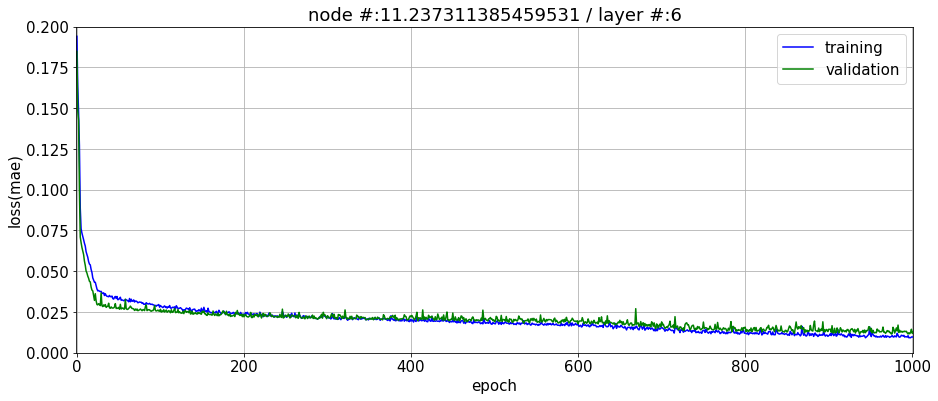

In [ ]:
plt.plot(pd.DataFrame(history.history)[['loss']], 'b', label='training')
plt.plot(pd.DataFrame(history.history)[['val_loss']], 'g', label='validation')
# plt.figure(figsize=(5,5), dpi=10000, facecolor='w', edgecolor='k')
plt.xlabel("epoch")
plt.ylabel("loss(mae)")  # "Loss(MAE)"  logcosh
plt.rcParams['figure.figsize'] = [15, 6]
font = {'weight' : 'normal', 'size' : 15}
plt.rc('font', **font)
plt.title('node #:' + str(nodeNum)+' / layer #:'+str(layerNum))
plt.grid(True)
plt.legend()
plt.xlim(-1, epochNum+1)
plt.ylim(0, 0.2)
plt.savefig(myPath+'log/_LearningCurve_'+case_name+'.png', dpi=300)
plt.show()

In [ ]:
def model_yhat(X, y, model, n_steps, n_features):
  m = y.shape[0]
  y_hat = []
  for i in range(m):
    y_hat.append(model.predict(X[i].reshape((-1, n_steps, n_features)), verbose=0)[0])
  return(y_hat)  

In [ ]:
i=1100
print(model.predict(mX_train[i].reshape(-1,4,28)))
Y_train[i]

[[ 5.08e-05  9.98e-01  2.14e-03 -3.71e-05 -1.09e-03]]


array([0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
trainy_hat = model_yhat(mX_train, Y_train, model, n_steps, n_features)

In [ ]:
testy_hat = model_yhat(mX_test, Y_test, model, n_steps, n_features)

In [ ]:
print(trainy_hat[10])

[-5.26e-03 -1.36e-03  1.00e+00 -3.50e-04  4.98e-04]


## Plot: train and test prediction

In [ ]:
n0, n1 = 10,15
print(np.array_str(np.array(trainy_hat)[n0:n1,:], precision=2, suppress_small=True))
print(np.array_str(Y_train[n0:n1,:], precision=2, suppress_small=True))

[[-0.01 -0.    1.   -0.    0.  ]
 [-0.    0.    0.    1.   -0.  ]
 [-0.    1.    0.    0.   -0.  ]
 [-0.   -0.    1.   -0.    0.  ]
 [ 0.08  1.01 -0.03 -0.04 -0.01]]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [ ]:
n0, n1 = 10,15
print(np.array_str(np.array(testy_hat)[n0:n1,:], precision=2, suppress_small=True))
print(np.array_str(Y_test[n0:n1,:], precision=2, suppress_small=True))

[[-0.    0.    0.    1.    0.  ]
 [-0.    1.    0.    0.   -0.  ]
 [-0.   -0.    1.   -0.    0.  ]
 [ 0.01  0.    0.01  0.98  0.01]
 [-0.   -0.    1.   -0.    0.  ]]
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
diff_train = abs(Y_train - np.array(trainy_hat))
diff_test = abs(Y_test - np.array(testy_hat))
print(np.array_str(diff_train[n0:n1,:], precision=2, suppress_small=True))
print(np.array_str(diff_test[n0:n1,:], precision=2, suppress_small=True))

[[0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.08 0.01 0.03 0.04 0.01]]
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.01 0.   0.01 0.02 0.01]
 [0.   0.   0.   0.   0.  ]]


In [ ]:
error_train = np.linalg.norm(diff_train, axis=1)
error_test = np.linalg.norm(diff_test, axis=1)
print(np.array_str(error_train[n0:n1], precision=2, suppress_small=True))
print(np.array_str(error_test[n0:n1], precision=2, suppress_small=True))

[0.01 0.01 0.   0.   0.1 ]
[0.01 0.   0.   0.02 0.  ]


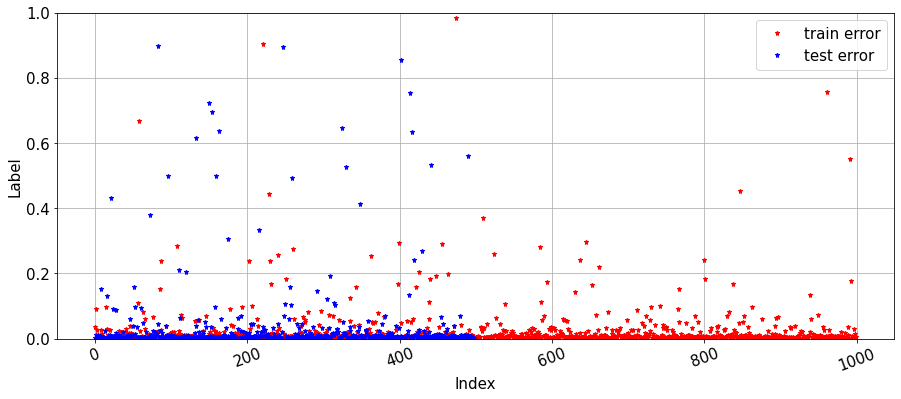

In [ ]:
n0, n1 = 0, 1000
plt.plot(error_train[n0:n1], 'r*', label='train error', markersize=5)
plt.plot(error_test[n0:n1], 'b*', label='test error', markersize=5)

#plt.title('node #:' + str(nodeNum)+' / layer #:'+str(layerNum)+' / batch #:'+str(batchNum))
plt.ylim(0, 1)
plt.ylabel('Label')
plt.xlabel('Index')
plt.xticks(rotation=20)

plt.rcParams['figure.figsize'] = [15, 6]
plt.grid(True)
plt.legend()
plt.savefig(myPath+'log/_timeseries'+case_name+'.png', dpi=300)
plt.show()